In [1]:
import pandas as pd
import numpy as np
import warnings

from scipy import special 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import math
from IPython.display import Markdown, display ,HTML


from sklearn.model_selection import train_test_split


sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 


warnings.filterwarnings('ignore')
import sklearn.preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import re

**Utility Methods**

In [2]:
def log(string):
    display(Markdown("> <span style='color: black'>"+string+"</span>"))
    
def header(string):
    display(Markdown('--------'))
    display(Markdown('### '+string))

def header_red(string):
    display(Markdown("> <span style='color: red'>"+string))
    
def get_variable_type(element):
    """
    Check whether columns are of Continuous or Categorical varibale.
    Assumption is that if 
                unique count < 20 then categorical
                unique count >= 20 and dtype = [int64 or float 64] then continuous 
    """
    if element == 0:
        return 'Not Known'
    elif element < 20 and element!=0:
        return 'Categorical'
    elif element >= 20 and element!=0:
        return 'Continuous'
    
def get_meta_data(dataframe):
    """
     Method to get Meta-Data about any dataframe passed
    """
    metadata_matrix = pd.DataFrame({
                     'Datatype': dataframe.dtypes.astype(str),
                     'Non_Null_Count': dataframe.count(axis = 0).astype(int),
                     'Null_Count': dataframe.isnull().sum().astype(int),
                     'Null_Percentage': dataframe.isnull().sum()/len(dataframe)*100,
                     'Unique_Values_Count': dataframe.nunique().astype(int)
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix

def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header('Columns with only one unique value: '+str(lenght))
    if lenght == 0:
        header_red('No columns with only one unique values.')
    else:
        log('Columns with only one unique value: ')
        for index, item in enumerate(drop_value_col):
            print(index,".",item)
        
def predict_variable_type(metadata_matrix):
    metadata_matrix['Variable_Type'] = metadata_matrix['Unique_Values_Count'].apply(get_variable_type).astype(str)
    metadata_matrix['frequency'] = metadata_matrix['Null_Count'] - metadata_matrix['Null_Count']
    metadata_matrix['frequency'].astype(int)
    return metadata_matrix

def list_potential_categorical_type(dataframe, main):
    header('Stats for potential Categorical datatype columns')
    metadata_matrix_categorical = dataframe[dataframe['Variable_Type'] == 'Categorical']
    # TO DO *** Add check to skip below if there is no Categorical values
    length = len(metadata_matrix_categorical)
    if length == 0:
        header_red('No Categorical columns in given dataset.')
    else:
        metadata_matrix_categorical = metadata_matrix_categorical.filter(['Datatype', 'Unique_Values_Count'])
        metadata_matrix_categorical.sort_values(['Unique_Values_Count'], axis = 0, ascending = False, inplace = True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check:
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({'index': name_list, 'Unique_Values': values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical, temp, how = 'inner', on = 'index')
        display(metadata_matrix_categorical.set_index('index'))
        
def plot_data_type_pie_chart(dataframe):
    header('Stats for Datatype Percentage Distribution')
    dataframe_group = dataframe.groupby('Datatype').frequency.count().reset_index()
    dataframe_group.sort_values(['Datatype'], axis = 0, ascending = False, inplace = True)
    trace = go.Pie(labels = dataframe_group['Datatype'].tolist(), values = dataframe_group['frequency'].tolist())
    layout = go.Layout(title = 'Datatype Percentage Distribution')
    fig = go.Figure(data = [trace], layout = layout)
    py.offline.iplot(fig)
    
def get_potential_categorical_type(dataframe, main, unique_count):
    metadata_matrix_categorical = dataframe[dataframe['Variable_Type'] == 'Categorical']
    metadata_matrix_categorical = dataframe[dataframe['Unique_Values_Count'] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0:
        header_red('No Categorical columns in given dataset.')
    else: 
        metadata_matrix_categorical = metadata_matrix_categorical.filter(['Datatype', 'Unique_Values_Count'])
        metadata_matrix_categorical.sort_values(['Unique_Values_Count'], axis = 0, ascending = False, inplace = True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check:
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({'index': name_list, 'Unique_Values': values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical, temp, how = 'inner', on = 'index')
        display(metadata_matrix_categorical.set_index('index'))

def color_red(val):
    """
    Takes a scalae and returns a string with
    the css property `'color:red'` for value
    greater than 10, black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def heatmap(x, y, dataframe):
    plt.figure(figsize = (x,y))
    sns.heatmap(dataframe.corr(), cmap = 'OrRd', annot = True)
    plt.show()

**Loading Dataset For Analysis**

In [3]:
# Loading csv file of our dataset i.e telecom_churn_data.csv
telecom_df = pd.read_csv('telecom_churn_data.csv')
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,NaN,252.00,252.00,252.00,NaN,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.00,0.00,0.00,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.00,1.00,1.00,NaN,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,355.07,268.32,86.28,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.00,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,...,NaN,NaN,154.00,50.00,NaN,0.00,108.07,365.47,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.00,0.00,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.00,1.00,NaN,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,189.06,210.23,290.71,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.00,0.00,0.00,38.49,0.00,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,22.24,0.00,135.54,45.76,0.48,60.66,67.41,67.66,64.81,4.34,...,0.00,NaN,NaN,NaN,46.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,251.10,508.05,389.50,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.00,54.86,44.38,0.00,0.00,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,2.06,0.00,0.00,0.00,0.00,183.03,118.68,37.99,83.03,26.23,...,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,309.88,238.17,163.43,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,1.93,0.00,0.00,0.00,0.00,117.96,241.33,208.16,98.61,0.00,...,NaN,56.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00


**Data Preparation**

In [4]:
# Checking shape of dataset
telecom_df.shape

(99999, 226)

In [5]:
# Summary of our DataFrame
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [6]:
# Checking statistical data for our dataframe
telecom_df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,"99,999.00","99,999.00","98,981.00","98,981.00","98,981.00","99,999.00","99,999.00","99,999.00","99,999.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00",...,"25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00"
mean,"7,001,207,270.39",109.00,0.00,0.00,0.00,282.99,278.54,279.15,261.65,132.40,133.67,133.02,130.30,197.94,197.05,196.57,190.34,9.95,7.15,7.29,6.34,13.91,9.82,9.97,8.56,47.10,46.47,45.89,44.58,93.34,91.40,91.76,90.46,3.75,3.79,3.68,3.66,1.12,1.37,1.43,1.23,144.20,141.67,141.33,138.71,79.83,83.30,83.28,82.34,87.30,...,0.66,192.60,200.98,197.53,192.73,51.90,51.23,50.17,44.72,121.40,129.00,135.41,136.06,89.56,89.38,91.17,100.26,86.40,85.91,86.60,93.71,0.03,0.02,0.02,0.02,0.08,0.08,0.08,0.07,0.39,0.44,0.45,0.39,0.08,0.08,0.08,0.09,0.07,0.08,0.08,0.08,0.91,0.91,0.89,0.86,"1,219.85",68.17,66.84,60.02,3.30
std,"695,669.39",0.00,0.00,0.00,0.00,328.44,338.16,344.47,342.00,297.21,308.79,308.95,308.48,316.85,325.86,327.17,319.40,72.83,73.45,68.40,57.14,71.44,58.46,64.71,58.44,150.86,155.32,151.18,148.00,162.78,157.49,156.54,158.68,14.23,14.26,13.27,13.46,5.45,7.53,6.78,5.62,251.75,248.73,245.91,245.93,252.48,263.63,265.49,267.18,255.62,...,1.41,192.65,196.79,191.30,188.40,213.36,212.30,212.35,198.65,544.25,541.49,558.78,577.39,193.12,195.89,188.18,216.29,172.77,176.38,168.25,171.38,0.16,0.15,0.14,0.13,0.30,0.30,0.30,0.28,1.50,1.64,1.63,1.35,0.36,0.39,0.38,0.38,0.57,0.63,0.66,0.65,0.28,0.29,0.31,0.35,954.73,267.58,271.20,253.94,32.41
min,"7,000,000,074.00",109.00,0.00,0.00,0.00,"-2,258.71","-2,014.05",-945.81,"-1,899.51",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In churn prediction, we assume that there are three phases of customer lifecycle:

The 'good' phase [Month 6 & 7]

The 'action' phase [Month 8]

The 'churn' phase [Month 9]

In this case, since you are working over a four-month window, the first two months are the 'good' phase, the third month is the 'action phase', the third month is the 'action' phase, while the fourth month is the 'churn' phase.

**1. Derive New Features**

In [7]:
# Let us first extract list of columns containing recharge amount
amt_recharge_columns = telecom_df.columns[telecom_df.columns.str.contains('rech_amt|rech_data')]
print(amt_recharge_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


Analysis: From above features we can derive more meaningful information

Total recharge amount

Total recharge for data

Last date of recharging the data

Average recharge amount for data

Maximum recharge for data

In [8]:
# Checking missing values percentages
telecom_df_null_check = 100*telecom_df.loc[:,amt_recharge_columns].isnull().sum()/len(telecom_df)
df = pd.DataFrame(telecom_df_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace = True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
total_rech_amt_9,0.000000
max_rech_amt_6,0.000000
max_rech_amt_7,0.000000
max_rech_amt_8,0.000000
max_rech_amt_9,0.000000
date_of_last_rech_data_6,74.846748
date_of_last_rech_data_7,74.428744


Analysis: We can see more than 74% values for recharge related data are missing.

In [9]:
telecom_df.loc[:, amt_recharge_columns].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,"99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00"
mean,327.51,322.96,324.16,303.35,104.64,104.75,107.73,101.94,2.46,2.67,2.65,2.44,126.39,126.73,125.72,124.94,192.60,200.98,197.53,192.73
std,398.02,408.11,416.54,404.59,120.61,124.52,126.90,125.38,2.79,3.03,3.07,2.52,108.48,109.77,109.44,111.36,192.65,196.79,191.30,188.40
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00
25%,109.00,100.00,90.00,52.00,30.00,30.00,30.00,28.00,1.00,1.00,1.00,1.00,25.00,25.00,25.00,25.00,82.00,92.00,87.00,69.00
50%,230.00,220.00,225.00,200.00,110.00,110.00,98.00,61.00,1.00,1.00,1.00,2.00,145.00,145.00,145.00,145.00,154.00,154.00,154.00,164.00
75%,437.50,428.00,434.50,415.00,120.00,128.00,144.00,144.00,3.00,3.00,3.00,3.00,177.00,177.00,179.00,179.00,252.00,252.00,252.00,252.00
max,"35,190.00","40,335.00","45,320.00","37,235.00","4,010.00","4,010.00","4,449.00","3,399.00",61.00,54.00,60.00,84.00,"1,555.00","1,555.00","1,555.00","1,555.00","7,546.00","4,365.00","4,076.00","4,061.00"


Analysis:

We can create new feature as total_rech_amt_data using total_rech_data and av_rech_amt_data to capture amount utilized by customer for data.

Also as the minimum value is 1 we can impute the NA values by 0, considering there were no recharges done by the customer.

In [10]:
telecom_df['total_rech_data_6'] = telecom_df['total_rech_data_6'].replace(np.NaN,0.0)
telecom_df['total_rech_data_7'] = telecom_df['total_rech_data_7'].replace(np.NaN,0.0)
telecom_df['total_rech_data_8'] = telecom_df['total_rech_data_8'].replace(np.NaN,0.0)

In [11]:
telecom_df['av_rech_amt_data_6'] = telecom_df['av_rech_amt_data_6'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_7'] = telecom_df['av_rech_amt_data_7'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_8'] = telecom_df['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [12]:
# Let's add new column total recharge amount for data: total_rech_amt_data for calculating High Value Customers process
telecom_df['total_rech_amt_data_6'] = telecom_df.av_rech_amt_data_6 * telecom_df.total_rech_data_6
telecom_df['total_rech_amt_data_7'] = telecom_df.av_rech_amt_data_7 * telecom_df.total_rech_data_7
telecom_df['total_rech_amt_data_8'] = telecom_df.av_rech_amt_data_8 * telecom_df.total_rech_data_8

Analysis: Defining total average recharge amount for good phase for months 6 and 7 (the good phase)

In [13]:
telecom_df['total_avg_rech_amnt_6_7_GPhase'] = (telecom_df.total_rech_amt_6 + telecom_df.total_rech_amt_data_6\
                                               + telecom_df.total_rech_amt_7 + telecom_df.total_rech_amt_data_7)/2

**2. Filter High Value Customers**

Define High-Value Customers as follows:

Those who have recharged with an amount more than or equal to X is greater than 70th percentile of the average recharge mount in the first two months (the good phase)

In [14]:
# Create a filter for values greater than 70th percentile of total average recharge amouunt for good phase
high_value_filter = telecom_df.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)

print('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter))

telecom_df_high_val_cust = telecom_df[telecom_df.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
print('Dataframe Shape after filtering High Value Customers: '+str(telecom_df_high_val_cust.shape))

70 percentile of 6th and 7th months avg recharge amount: 478.0
Dataframe Shape after filtering High Value Customers: (29953, 230)


**3. Tag churners and remove attributes of the churn phase**

Tag churners and remove attributes of the churn phase

Now tag the churned customers [churn = 1, else 0] based on the fourth month as follows:

Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.

The attributes you need to use to tag churners are **total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase(all attributes having '_9', etc. in their names)

In [15]:
high_val_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']

In [16]:
# Checking the NA/Null values are present or Not
df = 100 * telecom_df_high_val_cust.loc[:, high_val_cust_9].isnull().sum()/len(telecom_df_high_val_cust)
df = pd.DataFrame(df)
df.rename(columns = {0: 'Null_Percentage'}, inplace = True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_ic_mou_9,0.000000
total_og_mou_9,0.000000
vol_2g_mb_9,0.000000
vol_3g_mb_9,0.000000


In [17]:
# Initially set all the values as 0
telecom_df_high_val_cust['churn'] = 0

In [18]:
# is_churned boolean flag for customers where above values are zero
is_churned = (telecom_df_high_val_cust.total_ic_mou_9 == 0) & \
             (telecom_df_high_val_cust.total_og_mou_9 == 0) & \
             (telecom_df_high_val_cust.vol_2g_mb_9 == 0) & \
             (telecom_df_high_val_cust.vol_3g_mb_9 == 0)

In [19]:
# set all which having is churned True condition as 1
telecom_df_high_val_cust.loc[is_churned, 'churn'] = 1

In [20]:
# let us check what's the % of churned customers
100 * telecom_df_high_val_cust.churn.sum()/len(telecom_df_high_val_cust)

8.122725603445398

In [21]:
telecom_df_high_val_cust.shape

(29953, 231)

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having '_9', etc. in their names)

In [22]:
churn_month_columns = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('_9')]

In [23]:
# Drop all columns corresponding to the churn phase
telecom_df_high_val_cust.drop(churn_month_columns, axis = 1, inplace = True)

In [24]:
telecom_df_high_val_cust.shape

(29953, 177)

****EDA****

**1. Preprocess data (convert columns to appropriate formats, handle missing values, etc.)**

In [25]:
list_potential_categorical_type(get_meta_data(telecom_df_high_val_cust), telecom_df_high_val_cust)

--------

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
fb_user_8,float64,2,"[1.0, nan, 0.0]"


Analysis: Dropping above features with only one unique value as they will not add any value to our model building analysis

In [26]:
drop_col_with_unique_col = ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                            'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                            'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 
                           'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

In [27]:
print('Features before dropping unique values: '+str(telecom_df_high_val_cust.shape[1]))
telecom_df_high_val_cust.drop(drop_col_with_unique_col, axis = 1, inplace = True)
print('Features after dropping unique values: '+str(telecom_df_high_val_cust.shape[1]))

Features before dropping unique values: 177
Features after dropping unique values: 164


In [28]:
meta_df = get_meta_data(telecom_df_high_val_cust)

Exploring Date Field

In [29]:
meta_df_count = meta_df[meta_df['Datatype'] == 'object']
date_col = meta_df_count.index.tolist()
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [30]:
telecom_df_high_val_cust[date_col].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014
21,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,NaN
23,6/18/2014,7/7/2014,8/24/2014,NaN,7/7/2014,8/6/2014


In [31]:
for col in date_col:
    telecom_df_high_val_cust[col] = pd.to_datetime(telecom_df_high_val_cust[col])

In [32]:
telecom_df_high_val_cust[date_col].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7,2014-06-27,2014-07-25,2014-08-26,NaT,NaT,NaT
8,2014-06-25,2014-07-31,2014-08-30,NaT,2014-07-31,2014-08-23
21,2014-06-30,2014-07-31,2014-08-31,NaT,NaT,NaT
23,2014-06-18,2014-07-07,2014-08-24,NaT,2014-07-07,2014-08-06


In [33]:
telecom_df_high_val_cust.head(8)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,...,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,...,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,3.58,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.00,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.00,0.00,0.00,0.00,0.00,10.23,0.00,...,23.00,NaN,2.00,3.00,NaN,0.00,0.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,NaN,0.00,19.83,NaN,0.00,0.00,NaN,0.00,0.00,0,1,0,0,1,3,0,0,0,0,0,0,NaN,1.00,1.00,315,21.03,910.65,122.16,0.00,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,763.29,934.69,938.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,720,0.00,0.00,0.00,0.00,0.00,0.00,0.00,640.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,131.91,133.68,182.14,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.01,0.00,0.10,0.00,17.71,0.00,...,179.00,NaN,0.00,0.00,NaN,2.00,2.00,0.00,356.00,270.00,0.00,0.48,0.01,0.00,599.09,"1,009.92",NaN,306.57,197.27,NaN,301.78,150.67,NaN,0.00,0.00,0,0,0,0,0,0,0,2,1,0,0,1,NaN,1.00,1.00,604,40.45,51.86,0.00,0.00,0.00,712.00,540.00,583.00,0
33,7000149764,977.02,"2,362.83",

In [34]:
list_potential_categorical_type(get_meta_data(telecom_df_high_val_cust),telecom_df_high_val_cust)

--------

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
night_pck_user_8,float64,2,"[0.0, nan, 1.0]"


**2. Conduct appropriate exploratory analysis to extract useful insights(whether directly useful for business or for eventual modelling/feature engineering)**

In [35]:
# Create box plot for 6th, 7th & 8th month
def plot_box_chart(attribute):
    plt.figure(figsize = (20,16))
    df = telecom_df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data = df, y = attribute+'_6', x = 'churn', hue = 'churn', 
                  showfliers = False, palette = ('plasma'))
    plt.subplot(2,3,2)
    sns.boxplot(data = df, y = attribute+'_7', x = 'churn', hue = 'churn', 
                  showfliers = False, palette = ('plasma'))
    plt.subplot(2,3,3)
    sns.boxplot(data = df, y = attribute+'_8', x = 'churn', hue = 'churn', 
                  showfliers = False, palette = ('plasma'))
    plt.show()

a. Recharge amount related variables

In [36]:
recharge_amnt_columns = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

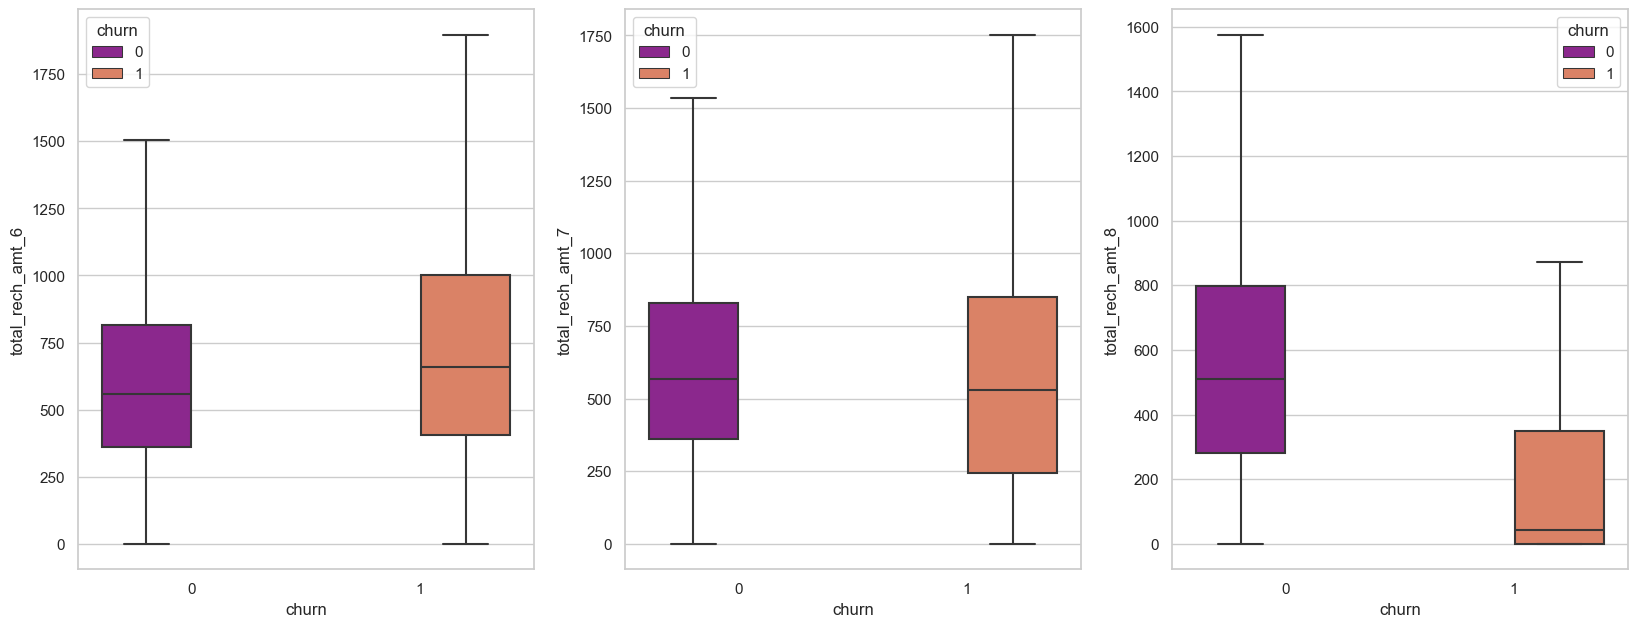

In [37]:
# Plotting for total recharge amount 
plot_box_chart('total_rech_amt')

Analysis: We can observe a drop in the total recharge amount for churned customers in the 8th Month(Action Phase)

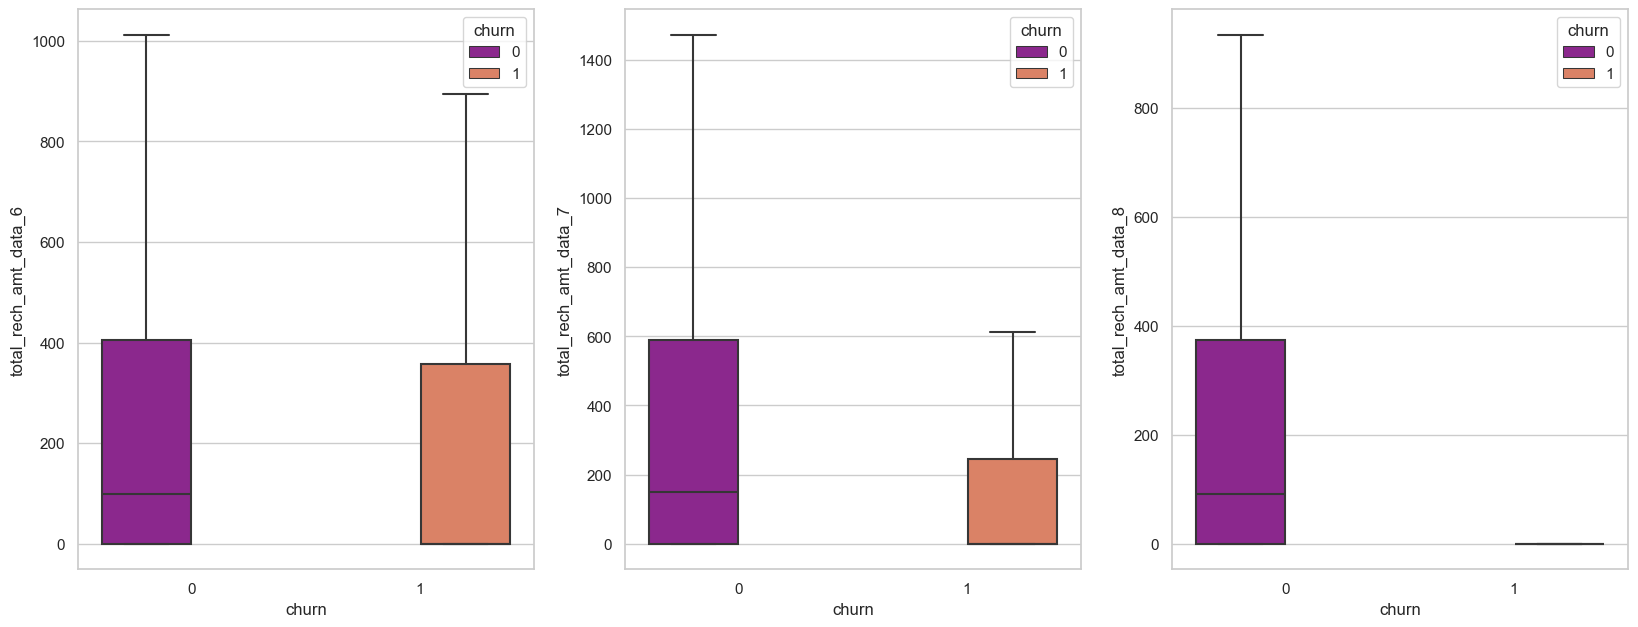

In [38]:
# Plotting for total recharge amount for data
plot_box_chart('total_rech_amt_data')

Analysis: We can observe that there is a huge drop in total recharge amount for data in the 8th Month(Action Phase) for churned customers

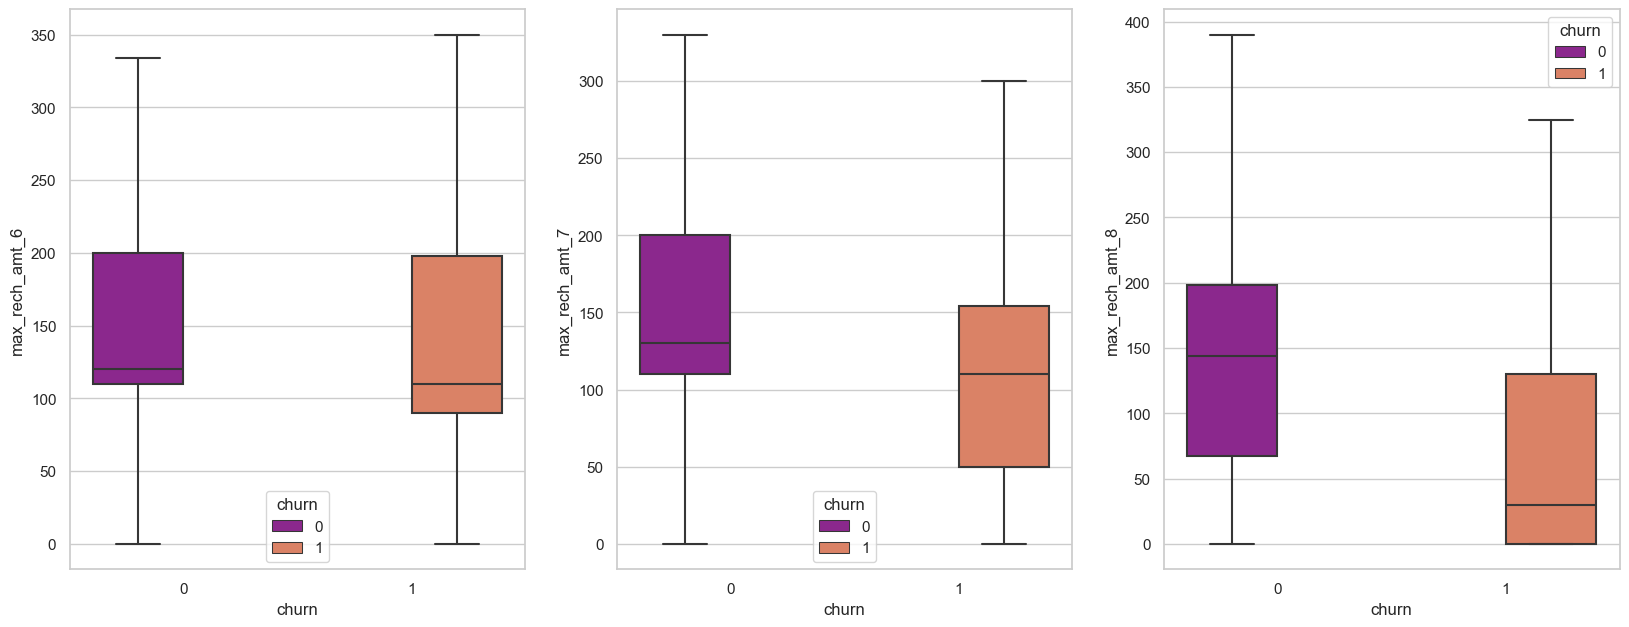

In [39]:
# Ploting for maximum recharge amount for data
plot_box_chart('max_rech_amt')

Analysis: We can observe that there is a huge drop in maximum recharge amount for data in the 9th Month(Action Phase) for churned customers.

In [40]:
# Let's check other recharge related variables
other_recharge = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_num|max_rech_data', regex = True)]

In [41]:
# Let's check the % of NA values for other recharge related variables
100*telecom_df_high_val_cust.loc[:, other_recharge].isnull().sum()/len(telecom_df_high_val_cust)

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
max_rech_data_6                   44.11
max_rech_data_7                   43.12
max_rech_data_8                   46.80
dtype: float64

In [42]:
telecom_df_high_val_cust.loc[:,['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,"16,740.00","17,038.00","15,935.00"
mean,139.80,140.44,136.35
std,118.89,120.30,119.57
min,1.00,1.00,1.00
25%,25.00,25.00,25.00
50%,152.00,152.00,152.00
75%,198.00,198.00,198.00
max,"1,555.00","1,555.00","1,555.00"


Analysis: We can observe that the minimum value is 1 while the max is 1555 across months, which indicate the missing values are where no recharges happened for the data. Filling the missing values by 0 means no recharge.

In [43]:
telecom_df_high_val_cust.loc[:,['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']]\
= telecom_df_high_val_cust.loc[:,['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']].replace(np.nan, 0)

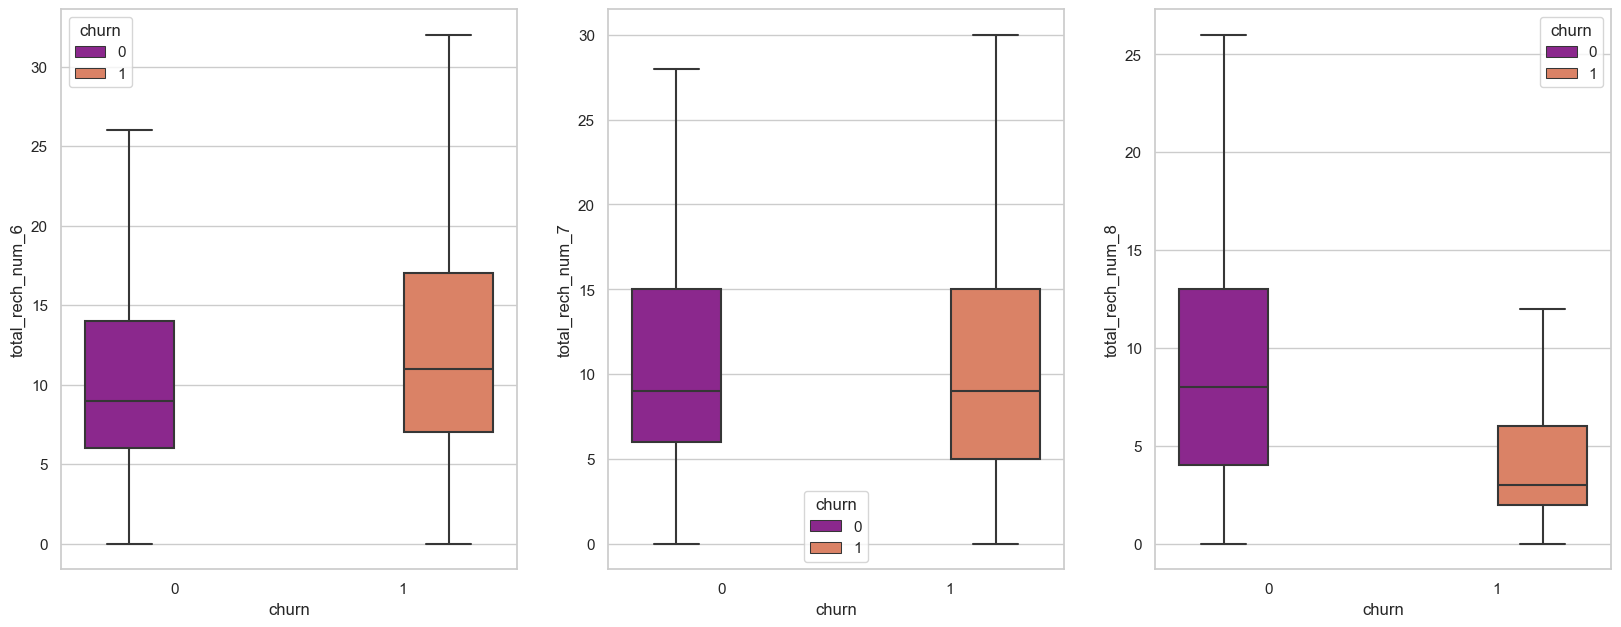

In [44]:

# Ploting for Total recharge for number
plot_box_chart('total_rech_num')

Analysis: We can see that there is a huge drop in total recharge number also in the 8th Month(Action Phase) for churned customers.

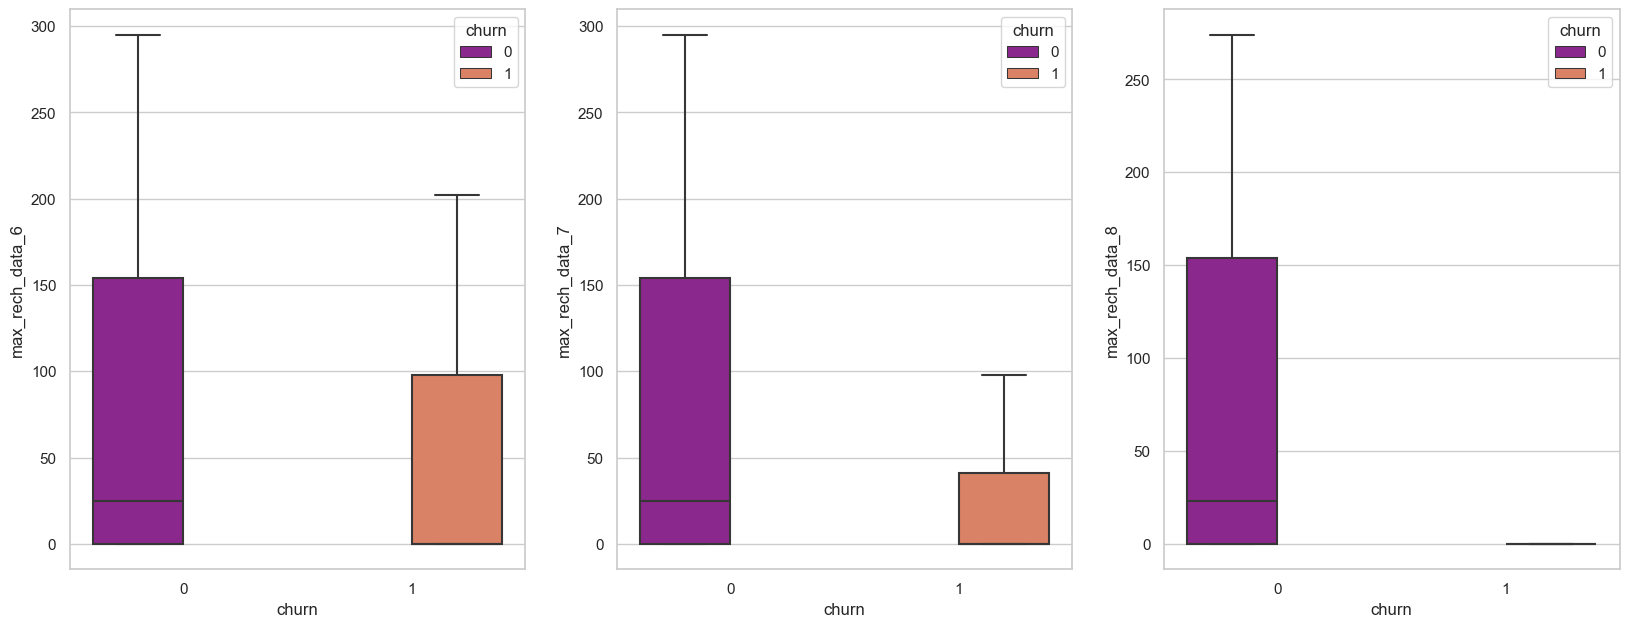

In [45]:
# Ploting for maximum recharge for data
plot_box_chart('max_rech_data')

Analysis: We can observe that there is a huge drop in maximum recharge for data also in the 8th Month(Action Phase) for churned customers.

In [46]:
# Getting the last day recharge amount columns
last_day_rech_amt = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('day')]

In [47]:
last_day_rech_amt.tolist()

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

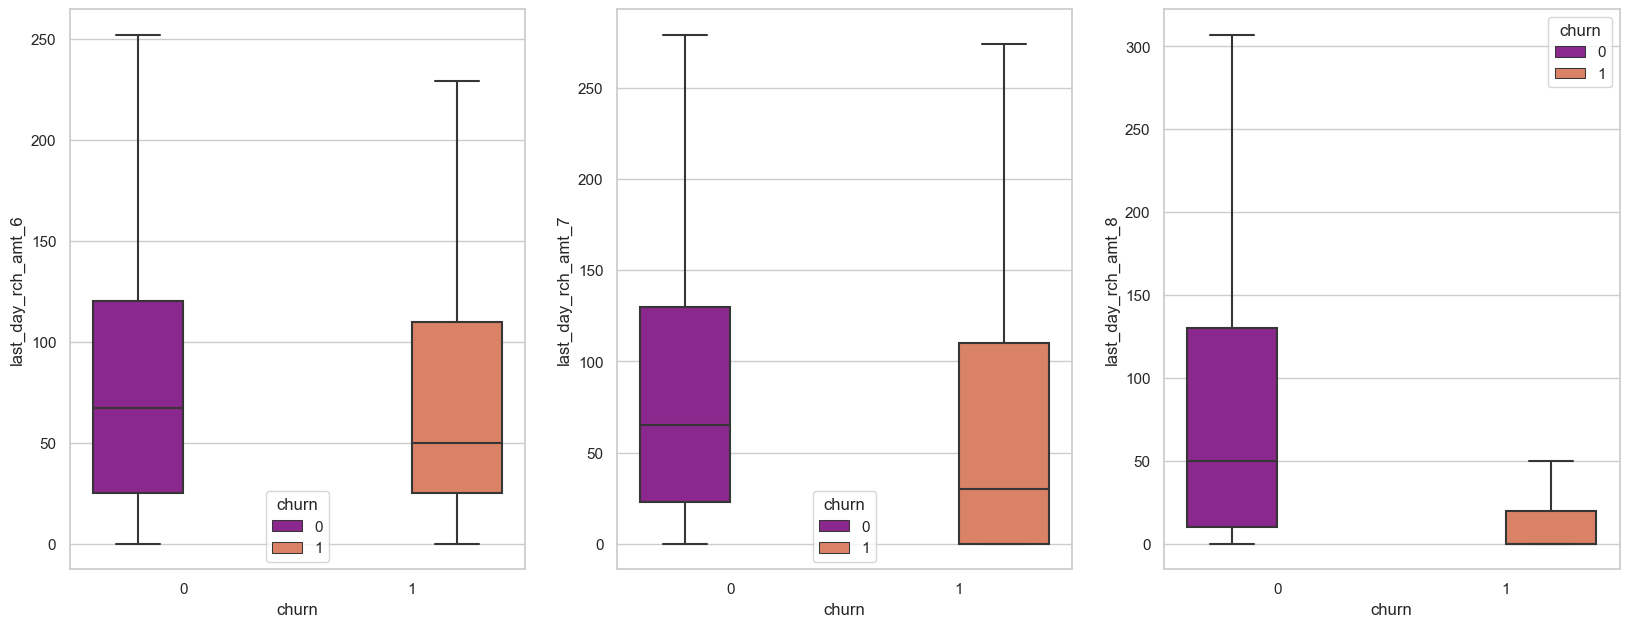

In [48]:
# Ploting for last day recharge amount
plot_box_chart('last_day_rch_amt')

Analysis: We are getting a huge drop in 8th Month(Action Phase) recharge amount for churned customers.

b. 2G and 3G usage related attributes

In [49]:
usage_2g_and_3g = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('2g|3g', regex = True)]

In [50]:
# Let's check % of NA values present
percentage_3g_2g_null_check = 100*telecom_df_high_val_cust.loc[:, usage_2g_and_3g].isnull().sum()\
/len(telecom_df_high_val_cust.loc[:, usage_2g_and_3g])
df = pd.DataFrame(percentage_3g_2g_null_check)
df.rename(columns={0: 'Null_Percentage'}, inplace = True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
count_rech_2g_6,44.112443
count_rech_2g_7,43.117551
count_rech_2g_8,46.799987
count_rech_3g_6,44.112443
count_rech_3g_7,43.117551
count_rech_3g_8,46.799987
vol_2g_mb_6,0.000000
vol_2g_mb_7,0.000000
vol_2g_mb_8,0.000000
vol_3g_mb_6,0.000000


Analysis: We are getting more than 40% values are not available for count of recharge and average for 2G/3G per user. Although we have 2G/3G volume usage based data available, we can drop these columns.

In [51]:
telecom_df_high_val_cust.drop(['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
                               'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
                             axis = 1, inplace = True)

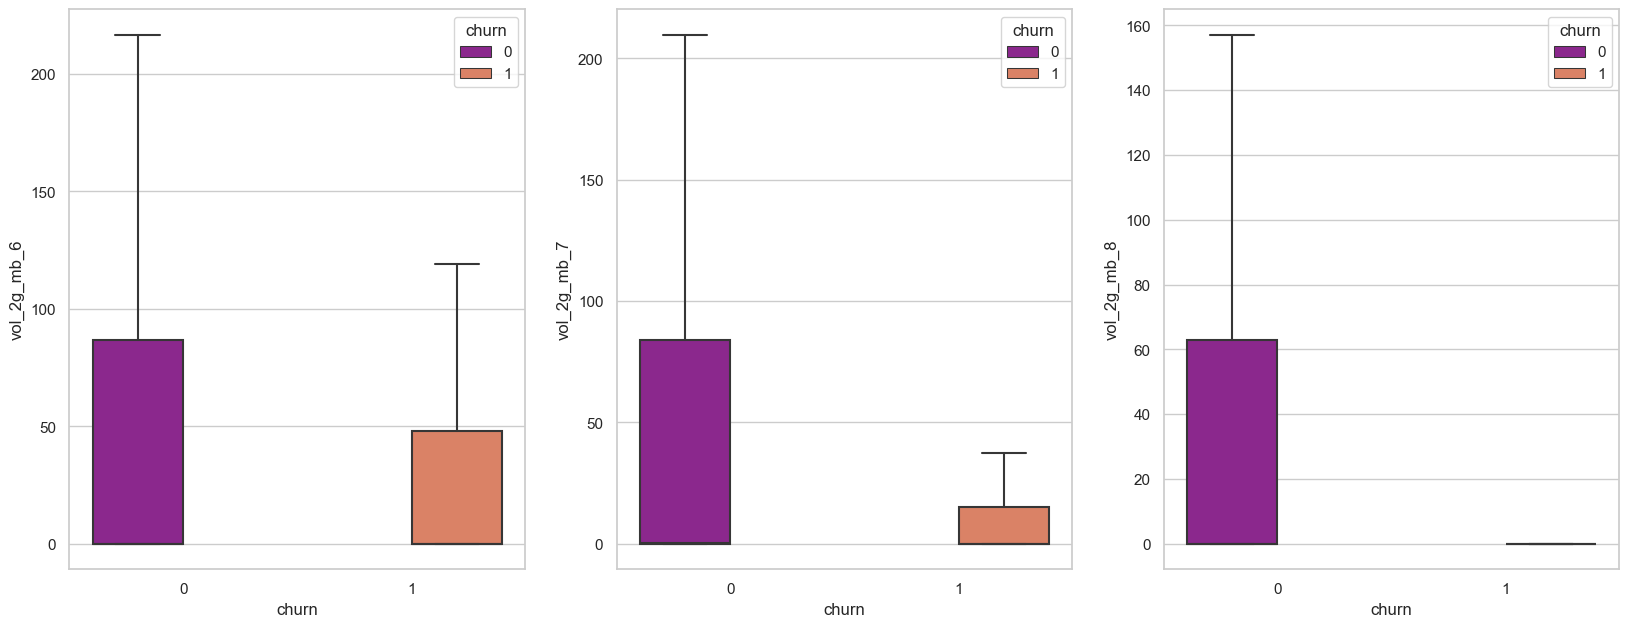

In [52]:
#Ploting for volume of 2G and 3G usage columns
plot_box_chart('vol_2g_mb')

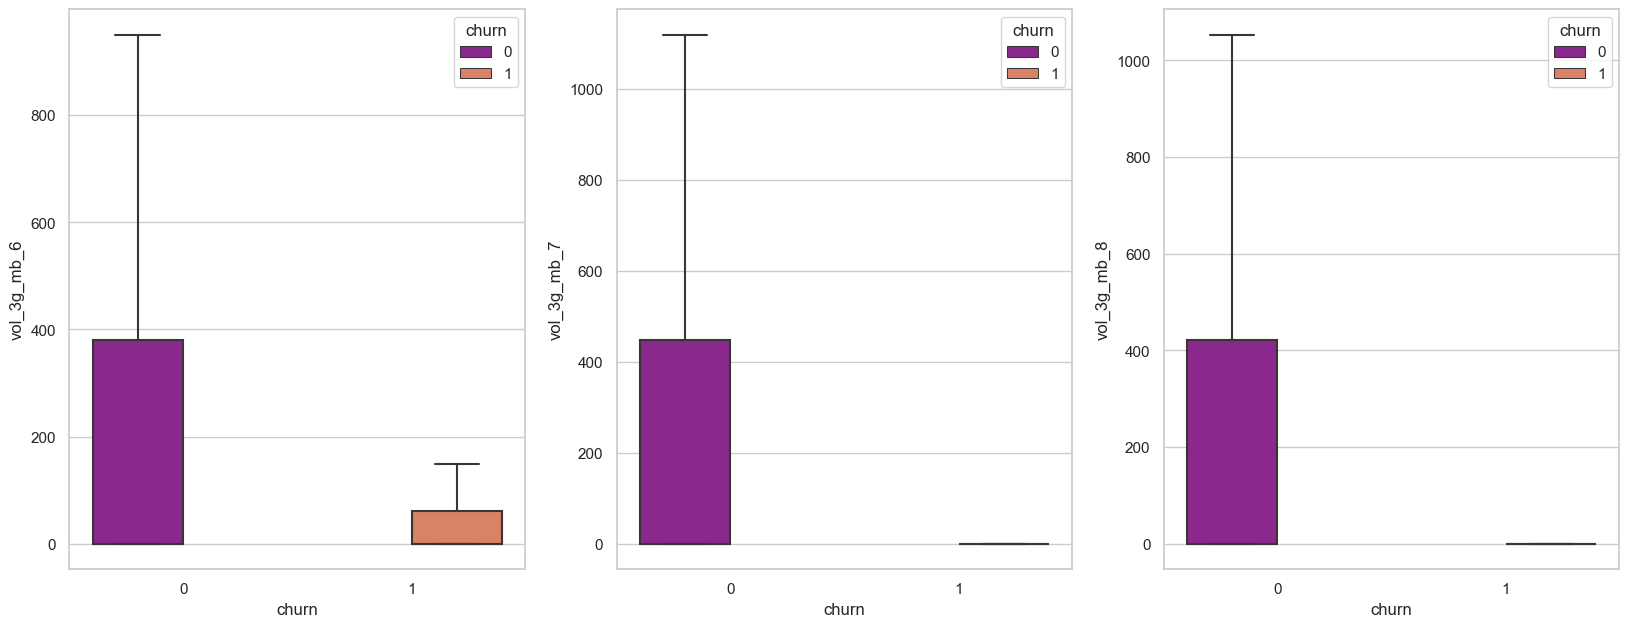

In [53]:
plot_box_chart('vol_3g_mb')

Analysis: We have two observations from above:

1) 2G and 3G usage for churned customers drops in 8th Month(Action Phase)
2) We can also observe that 2G/3G usage is higher for non-churned customers indicating that churned customers might be from areas where 2G/3G service is not properly available

In [54]:
# Let's check monthly 2G/3G service schemes
monthly_subscription_2g_3g = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('monthly_2g|monthly_3g', regex = True)]
monthly_subscription_2g_3g.tolist()

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [55]:
telecom_df_high_val_cust[monthly_subscription_2g_3g].info()

<class 'pandas.core.frame.DataFrame'>
Index: 29953 entries, 0 to 99997
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   monthly_2g_6  29953 non-null  int64
 1   monthly_2g_7  29953 non-null  int64
 2   monthly_2g_8  29953 non-null  int64
 3   monthly_3g_6  29953 non-null  int64
 4   monthly_3g_7  29953 non-null  int64
 5   monthly_3g_8  29953 non-null  int64
dtypes: int64(6)
memory usage: 1.6 MB


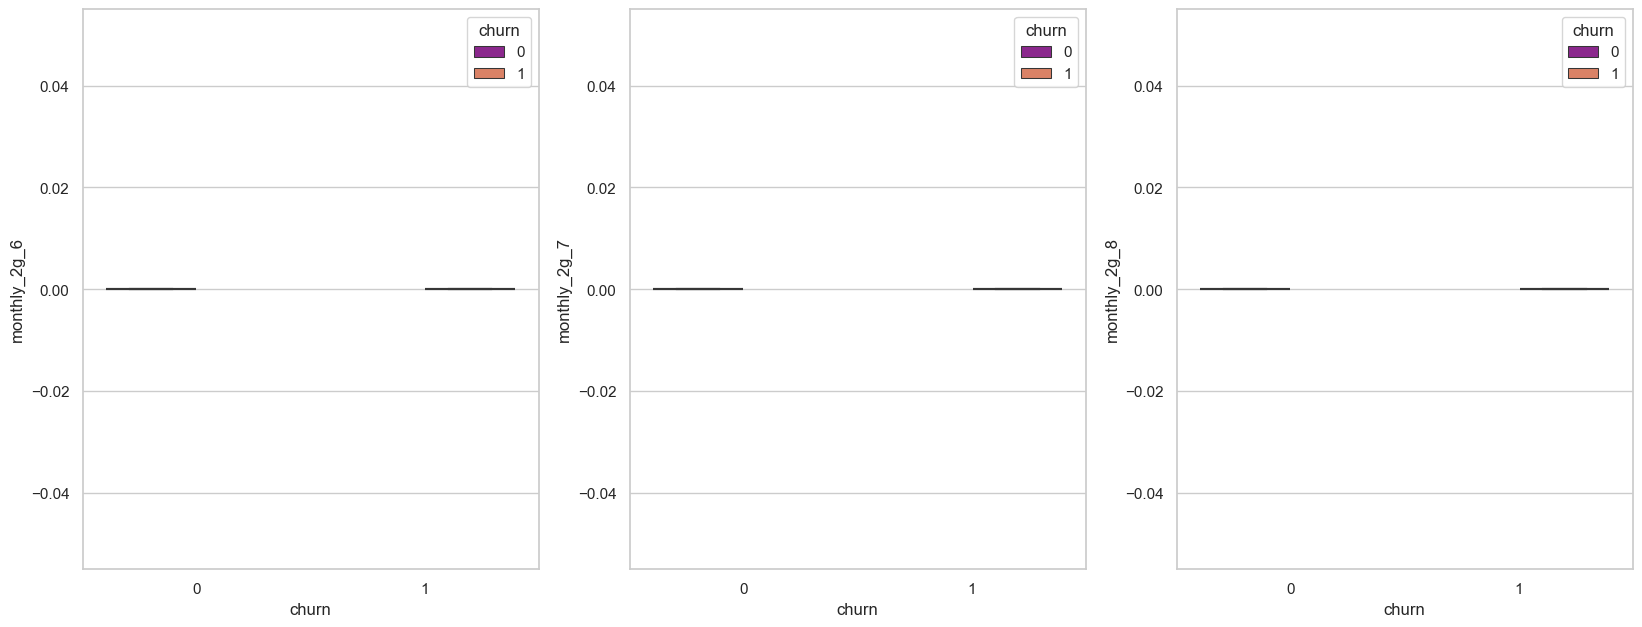

In [56]:
# Ploting for monthly subscription
plot_box_chart('monthly_2g')

Analysis: Value range is very low, hence graph is not giving us proper justification result. Hence, doing analysis by checking mean value.

In [57]:
def plot_mean_bar_chart(df, columns_list):
    df_0 = df[df.churn == 0].filter(columns_list)
    df_1 = df[df.churn == 1].filter(columns_list)
    
    mean_df_0 = pd.DataFrame([df_0.mean()], index = ['Non Churn'])
    mean_df_1 = pd.DataFrame([df_1.mean()], index = ['Churn'])
    
    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)
    
    mean_bar.T.plot.bar(figsize = (10,5), rot = 0)
    plt.show()
    
    return mean_bar

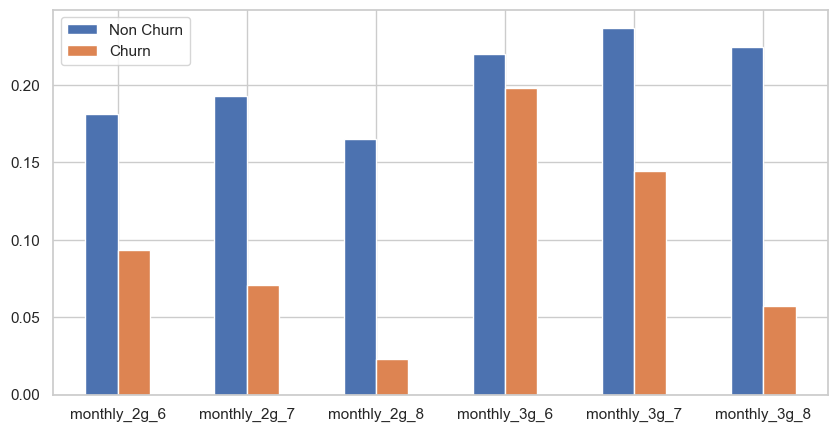

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.18,0.19,0.17,0.22,0.24,0.22
Churn,0.09,0.07,0.02,0.20,0.14,0.06


In [58]:
plot_mean_bar_chart(telecom_df_high_val_cust, monthly_subscription_2g_3g)

Analysis: Again we can see a drop in monthly subscription for churned customers in 8th Month.

In [59]:
# Let's check volume based cost
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_', regex = True)]
vbc_column.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']

In [60]:
# Renaming month based named vbc columns to 6,7,8,9 format
telecom_df_high_val_cust.rename(columns = {'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g':'vbc_3g_8',
                                          'sep_vbc_3g': 'vbc_3g_9'}, inplace = True)
# Drop the 9th column as it's not needed
telecom_df_high_val_cust.drop('vbc_3g_9', axis = 1, inplace = True)

In [61]:
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_3g', regex = True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

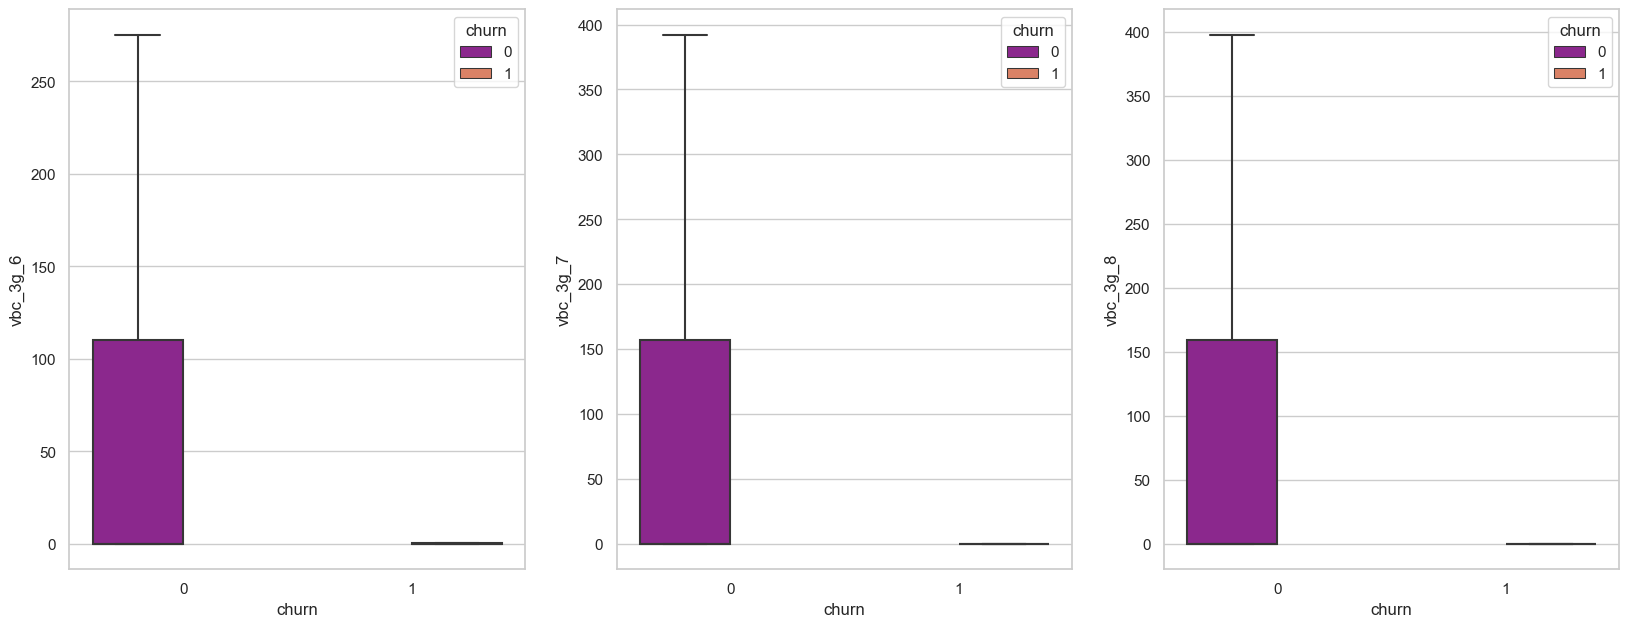

In [62]:
# Ploting for value based const
plot_box_chart('vbc_3g')

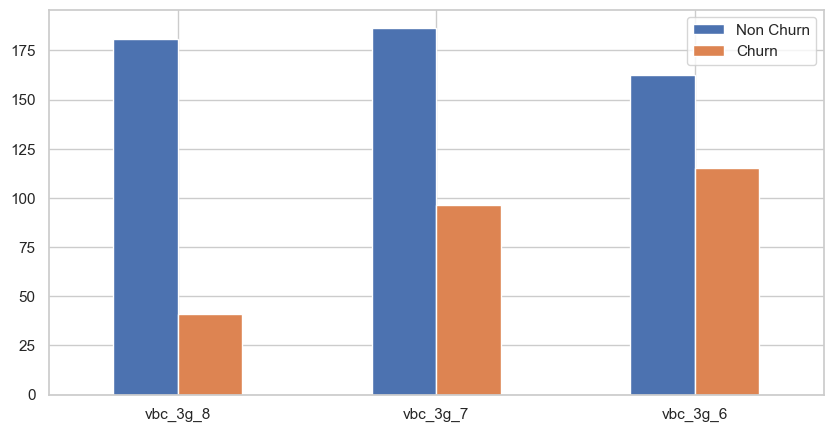

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,180.62,186.37,162.56
Churn,40.94,96.34,115.46


In [63]:
plot_mean_bar_chart(telecom_df_high_val_cust, vbc_column)

Analysis: Significantly it's ahowing that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned customers and also there is a drop in vbc in 8th month.

In [64]:
# Checking service schemes with validity smaller than a month for 2G/3G
SC_2g_3g_col = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('sachet_2g|sachet_3g', regex = True)]

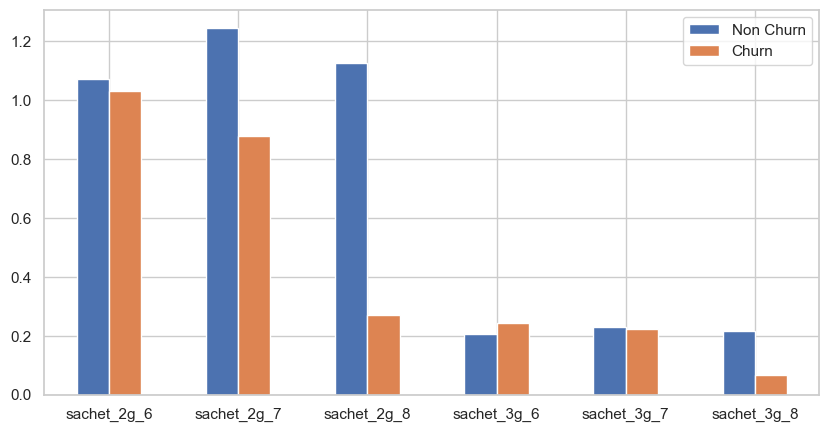

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.07,1.25,1.13,0.21,0.23,0.21
Churn,1.03,0.88,0.27,0.24,0.22,0.07


In [65]:
plot_mean_bar_chart(telecom_df_high_val_cust, SC_2g_3g_col)

Analysis: We can observe the drop in sachet services in 8th month for churned customers

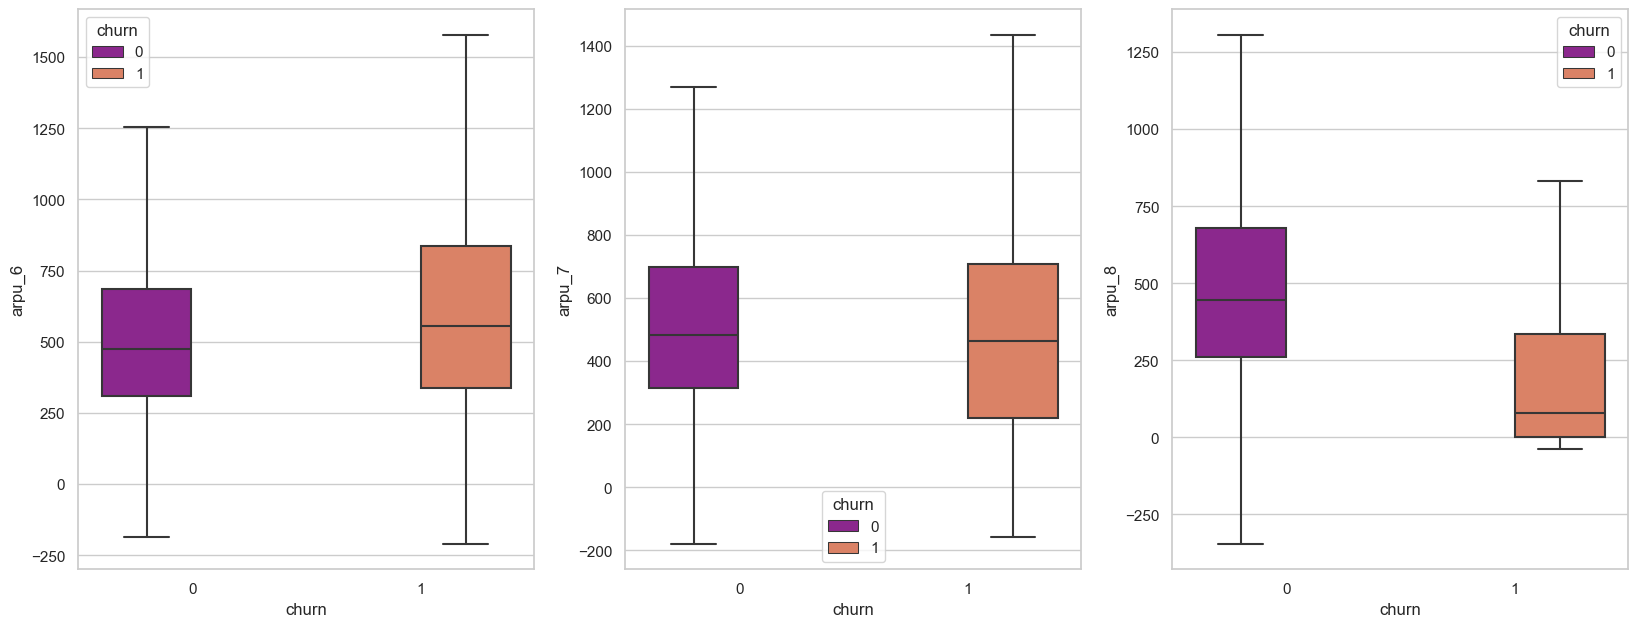

In [66]:
# Checking columns for average revenue per user
arpu_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('arpu_')]

#Ploting avg revenue per user
plot_box_chart('arpu')

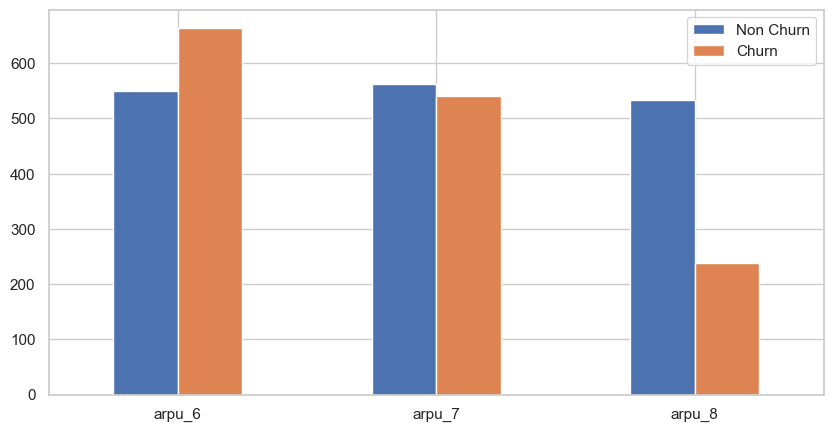

,arpu_6,arpu_7,arpu_8
Non Churn,549.55,562.93,532.87
Churn,663.71,541.15,237.66


In [67]:
plot_mean_bar_chart(telecom_df_high_val_cust, arpu_cols)

Analysis: We can observe that there's huge drop of avg revenue per user in 8th Month for churned customers.

e. Minutes of usage - voice calls

In [68]:
mou_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('mou')]

In [69]:
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [70]:
meta_df = get_meta_data(telecom_df_high_val_cust[mou_cols])
meta_df.sort_values(['Null_Percentage'], axis = 0, ascending = False, inplace = True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
isd_ic_mou_8,3.91
loc_ic_t2t_mou_8,3.91
loc_ic_t2m_mou_8,3.91
std_og_t2t_mou_8,3.91
loc_og_t2c_mou_8,3.91
...,...
total_ic_mou_6,0.00
total_ic_mou_7,0.00
total_ic_mou_8,0.00
total_og_mou_6,0.00


Analysis: So for all minutes of usage columns the maximum missing % is 3.91, means in this case the customer has not been used at all for that particular call type, thus we can fill the missing values with zero.

In [71]:
# Replacing null values by 0 for minutes of usage variables 
telecom_df_high_val_cust.loc[:, mou_cols] = telecom_df_high_val_cust.loc[:, mou_cols].replace(np.NaN, 0)

In [72]:
mou_og_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_og_.*mou_6', regex = True)]

In [73]:
telecom_df_high_val_cust.loc[:, mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,26.60,84.57,163.31,6.35,1.58,254.24,165.90,179.44,1.81,347.15,2.17,5.83,610.06
std,116.27,228.96,250.22,22.14,6.31,378.55,403.99,409.14,11.99,608.85,45.89,17.58,691.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,4.38,19.21,0.00,0.00,32.26,0.00,0.00,0.00,0.40,0.00,0.00,116.64
50%,0.00,24.36,77.26,0.00,0.00,124.59,2.71,16.36,0.00,45.08,0.00,0.23,410.63
75%,0.00,78.06,209.03,4.23,0.00,332.31,109.56,154.54,0.00,465.29,0.00,5.21,859.03
max,"3,775.11","6,431.33","4,729.74","1,466.03",271.44,"10,643.38","7,366.58","8,314.76",628.56,"8,432.99","5,900.66","1,023.21","10,674.03"


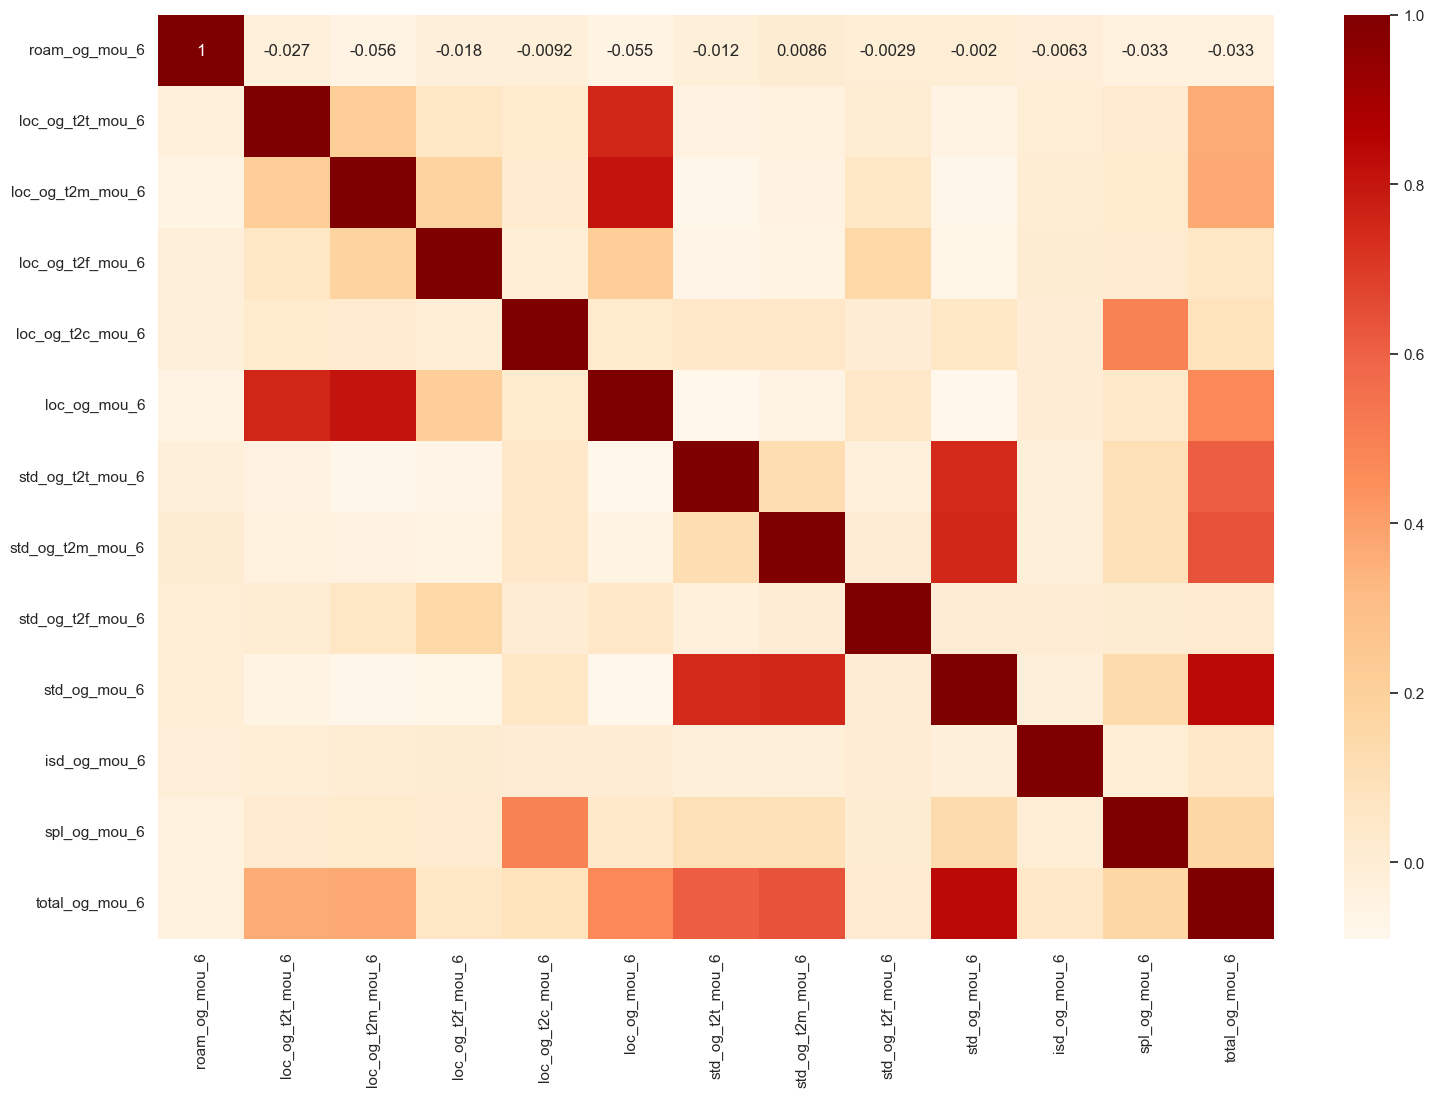

In [74]:
heatmap(18, 12, telecom_df_high_val_cust.filter(mou_og_cols6))

Analysis: We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 seems to have strong correlation with other fields and they needs to be inspected to avoid any multicolinearilty issues.

In [75]:
print(telecom_df_high_val_cust.loc[8, 'total_og_mou_6'], '==', 
      telecom_df_high_val_cust.loc[8, ['loc_og_mou_6', 'std_og_mou_6', 'spl_og_mou_6', 'isd_og_mou_6', 'og_others_6']].sum())
print(telecom_df_high_val_cust.loc[8, 'std_og_mou_6'], '==', 
     telecom_df_high_val_cust.loc[8, ['std_og_t2m_mou_6', 'std_og_t2t_mou_6', 'std_og_t2f_mou_6']].sum())
print(telecom_df_high_val_cust.loc[8, 'loc_og_mou_6'], '==', 
     telecom_df_high_val_cust.loc[8, ['loc_og_t2m_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6']].sum())

508.36 == 508.34999999999997
130.26 == 130.25
378.09 == 378.09


Analysis: We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 is a combination of other variables present in dataset. So we can remove these columns for all months from the dataset.

In [76]:
list_total_og_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou', regex = True)]
telecom_df_high_val_cust.drop(list_total_og_cols, axis = 1, inplace = True)
print('Columns dropped: ')
list_total_og_cols.tolist()

Columns dropped: 


['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

**Checking for incoming mou variables**

In [77]:
mou_ic_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_ic_.*mou_6', regex = True)]

In [78]:
telecom_df_high_val_cust.loc[:, mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,16.12,65.51,150.47,15.29,231.28,14.90,29.21,2.70,46.81,290.12,0.06,10.80
std,76.34,163.86,219.32,45.79,315.01,77.75,98.28,19.11,137.60,365.74,0.19,76.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.10,28.09,0.00,47.91,0.00,0.00,0.00,1.03,72.89,0.00,0.00
50%,0.00,25.08,84.11,1.84,134.56,0.38,5.00,0.00,11.41,183.78,0.00,0.00
75%,0.00,67.48,188.74,11.98,297.26,8.19,23.63,0.11,41.49,372.16,0.00,0.00
max,"2,613.31","6,351.44","4,693.86","1,678.41","7,454.63","5,459.56","4,630.23","1,351.11","5,459.63","7,716.14",19.76,"6,789.41"


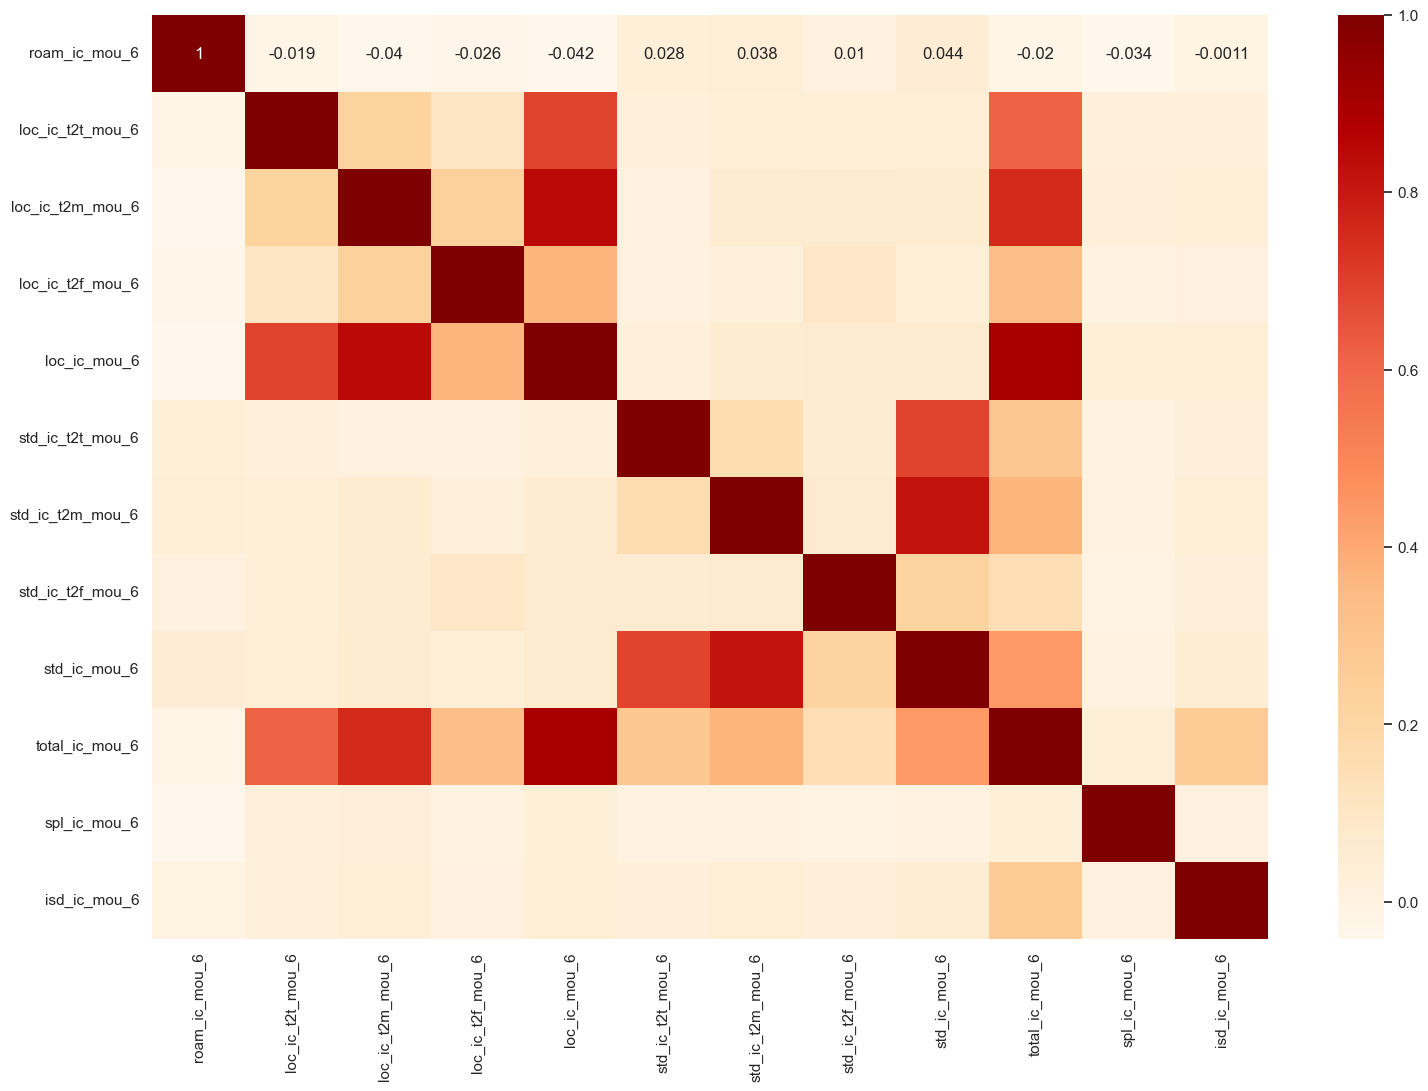

In [79]:
heatmap(18, 12, telecom_df_high_val_cust.filter(mou_ic_cols6))

Analysis: We can observe that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fields and they need to be inspected to avoid any multicolinearity issues.

In [80]:
print(telecom_df_high_val_cust.loc[21, 'total_ic_mou_6'], '==',
     telecom_df_high_val_cust.loc[21, ['loc_ic_mou_6', 'roam_ic_mou_6', 'isd_ic_mou_6', 'spl_ic_mou_6', 'std_ic_mou_6']].sum())
print(telecom_df_high_val_cust.loc[21, 'loc_ic_mou_6'], '==',
      telecom_df_high_val_cust.loc[21, ['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6']].sum())
print(telecom_df_high_val_cust.loc[21, 'std_ic_mou_6'], '==',
      telecom_df_high_val_cust.loc[21, ['std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6']].sum())

207.09 == 207.09
125.33 == 125.32000000000001
81.76 == 81.75


Analysis: We can see that total_ic_mou_6, std_ic_mou_6 & loc_ic_mou_6 is a combination of other variables present in dataset. So, we can remove these columns for all months from the dataset.

In [81]:
list_total_ic_cols = telecom_df_high_val_cust.columns[
    telecom_df_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou', regex = True)]
telecom_df_high_val_cust.drop(list_total_ic_cols, axis = 1, inplace = True)
print('Columns Dropped: ')
list_total_ic_cols.tolist()

Columns Dropped: 


['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

f. Offnet Usage

In [82]:
offnet_usage_service_col = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('offnet.*mou', regex = True)]

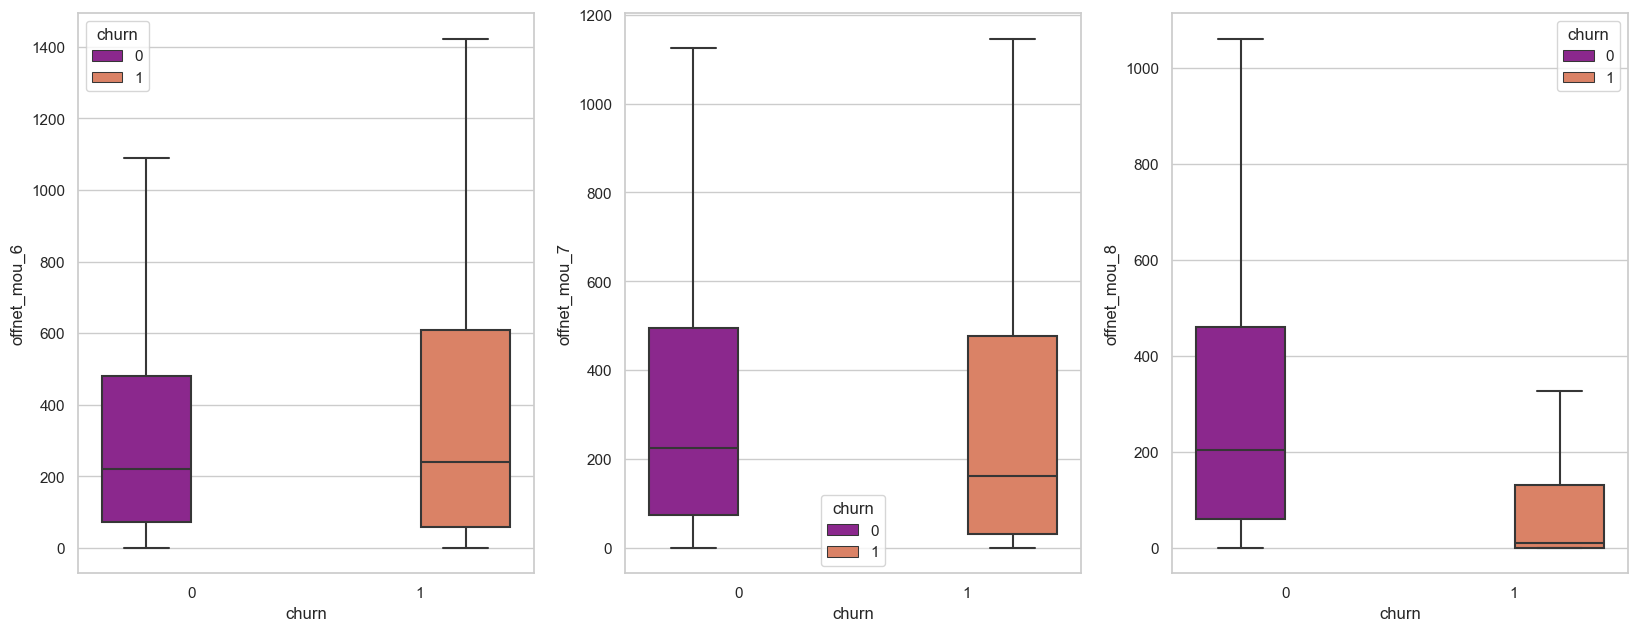

In [83]:
# Offnet mou values for churned and non churned customers
plot_box_chart('offnet_mou')

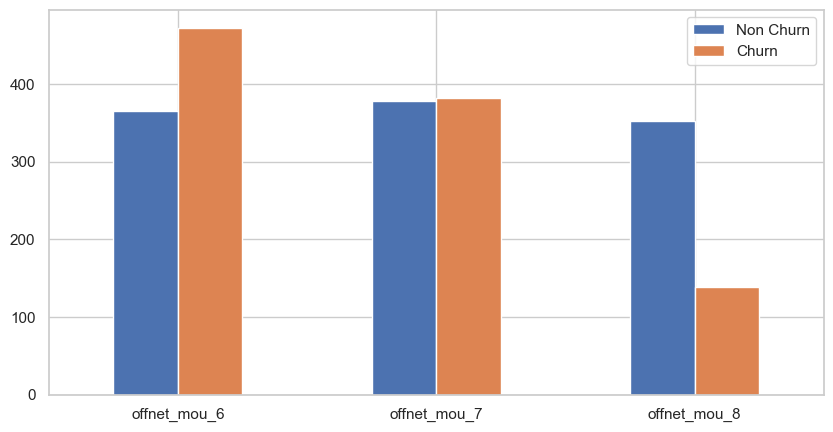

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,365.12,377.88,352.50
Churn,471.95,382.28,138.52


In [84]:
plot_mean_bar_chart(telecom_df_high_val_cust, offnet_usage_service_col)

Analysis: We can observe the drop for offnet mou services in the 8th month.

g. ONNET: All kind of calls within the same operator network

In [85]:
# Minutes of usage related columns
onnet_usage_service = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('^onnet.*mou', regex = True)]

In [86]:
onnet_usage_service.tolist()


['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']

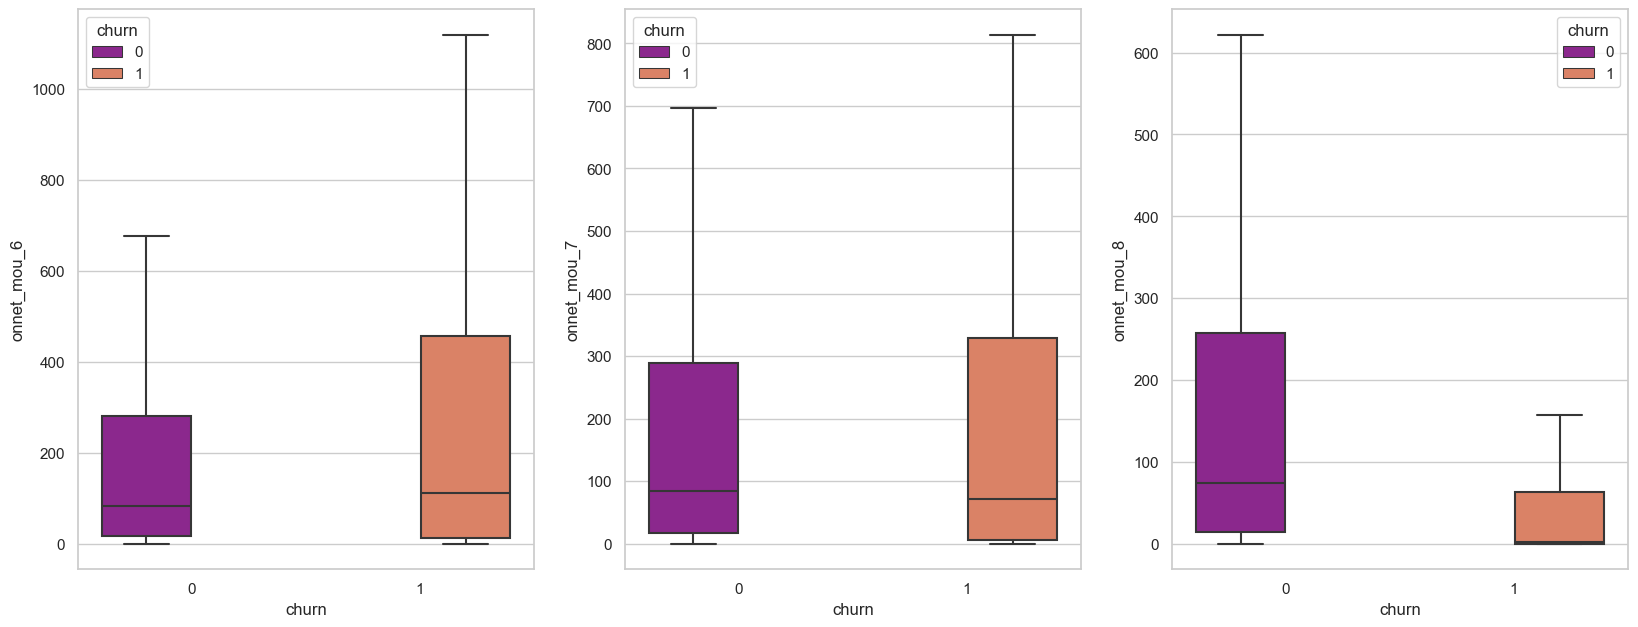

In [87]:
# Ploting onnet
plot_box_chart('onnet_mou')

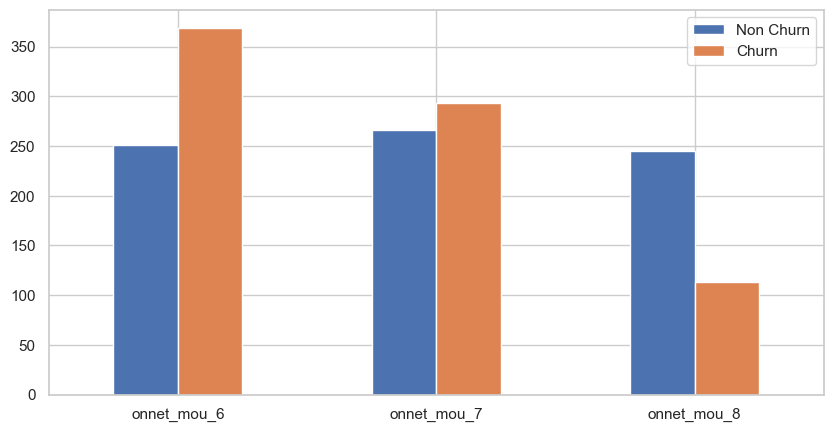

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,251.37,265.86,245.03
Churn,368.66,292.85,113.48


In [88]:
plot_mean_bar_chart(telecom_df_high_val_cust, onnet_usage_service)

Analysis: We can also observe here that there is a drop in Onnet usage in 8th month for churned customers.

h. Tenure Analysis for Customers

In [89]:
tenure_data = telecom_df_high_val_cust.copy()

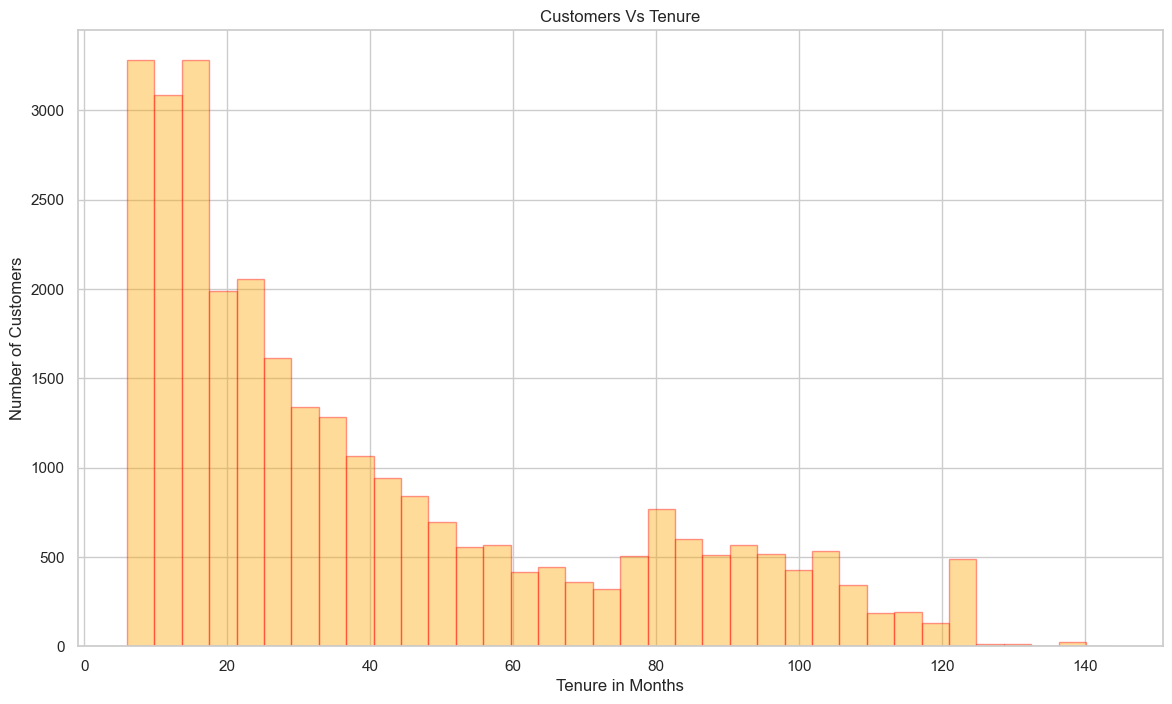

In [90]:
plt.figure(figsize = (14, 8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist = True, kde = False, 
                  bins = int(180/5), color = 'orange',
                  hist_kws = {'edgecolor': 'red'},
                  kde_kws = {'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [91]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = ['0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels = tn_label)
tenure_data['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

AttributeError: 'numpy.int64' object has no attribute 'startswith'

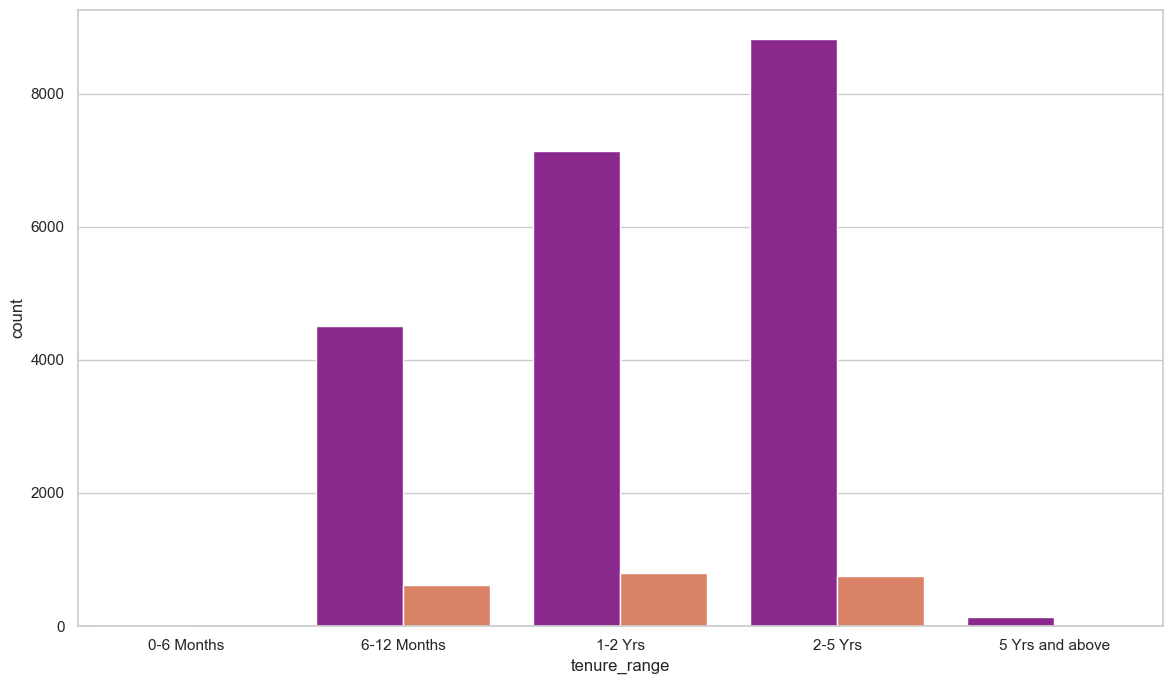

In [93]:
plt.figure(figsize = (14, 8))
sns.countplot(x = 'tenure_range', hue = 'churn', data = tenure_data, palette = ('plasma'))
plt.show()

**Checking columns with more than 30% NA values**

In [94]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df['Null_Percentage'] > 30]
meta_df.sort_values(['Null_Percentage'], axis = 0, ascending = False, inplace = True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_data_8,46.80
night_pck_user_8,46.80
fb_user_8,46.80
date_of_last_rech_data_6,44.11
night_pck_user_6,44.11
fb_user_6,44.11
date_of_last_rech_data_7,43.12
night_pck_user_7,43.12
fb_user_7,43.12


In [95]:
# Dropping 30% columns
is_more_30 = meta_df.index
telecom_df_high_val_cust.drop(telecom_df_high_val_cust[is_more_30], axis = 1, inplace = True)

In [96]:
telecom_df_high_val_cust.shape

(29953, 124)

**Replacing NAN Values**

In [97]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df['Null_Percentage'] > 0]
meta_df.sort_values(['Null_Percentage'], axis = 0, ascending = False, inplace = True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
og_others_8,3.91
ic_others_8,3.91
date_of_last_rech_8,1.94
og_others_6,1.81
ic_others_6,1.81
og_others_7,1.79
ic_others_7,1.79
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


In [98]:
telecom_df_high_val_cust[meta_df.index].head()

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,NaN,NaN,NaN,NaN,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25
21,0.00,0.00,2014-08-31,0.00,0.00,0.00,0.00,2014-07-31,2014-06-30
23,0.00,13.06,2014-08-24,0.00,0.00,0.00,5.35,2014-07-07,2014-06-18


**Exploring/Imputing Numeric Field**

In [99]:
numeric_col = ['og_others_8', 'ic_others_8', 'og_others_6', 'ic_others_6', 'og_others_7', 'ic_others_7']

Replacing NaN values with zero for all numeric data as most of the data is clean and will not impact the analysis

In [100]:
for i in numeric_col:
    telecom_df_high_val_cust.loc[telecom_df_high_val_cust[i].isnull(), i] = 0

In [101]:
telecom_df_high_val_cust[meta_df.index].head()

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,0.00,0.00,0.00,0.00,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25
21,0.00,0.00,2014-08-31,0.00,0.00,0.00,0.00,2014-07-31,2014-06-30
23,0.00,13.06,2014-08-24,0.00,0.00,0.00,5.35,2014-07-07,2014-06-18


In [102]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df['Null_Percentage'] > 0]
meta_df.sort_values(['Null_Percentage'], axis = 0, ascending = False, inplace = True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_8,1.94
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


**3. Derive New Features**

In [103]:
telecom_df_final = telecom_df_high_val_cust.copy()
print(telecom_df_final.shape)
telecom_df_final.head()

(29953, 124)


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,...,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,...,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,...,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,...,21,14,437,601,120,90,154,30,2014-06-25,2014-07-31,2014-08-30,50,0,10,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.48,10.19,19.54,118.23,...,26,27,600,680,718,50,50,50,2014-06-30,2014-07-31,2014-08-31,30,20,50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,720,0.00,0.00,0.00,0.00,0.00,0.00,640.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,0.00,0.01,0.00,0.10,0.00,17.71,0.00,0.00,0.00,20.71,61.04,76.64,95.91,...,5,4,0,454,439,0,179,179,2014-06-18,2014-07-07,2014-08-24,0,179,0,0.00,2.00,2.00,0.00,179.00,179.00,0.00,356.00,270.00,0.00

In [104]:
telecom_df_final.drop(['total_avg_rech_amnt_6_7_GPhase'], axis = 1, inplace = True)
telecom_df_final.drop(telecom_df_high_val_cust.filter(regex = 'date_').columns, axis = 1, inplace = True)
print(telecom_df_final.shape)

col_list = telecom_df_final.filter(regex = '_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = 'avg_'+col+'_av67'
    col_6 = col+'_6'
    col_7 = col+'_7'
    telecom_df_final[avg_col_name] = (telecom_df_final[col_6] + telecom_df_final[col_7])/2

(29953, 120)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [105]:
col_list_to_drop = telecom_df_final.filter(regex = '_6|_7')
telecom_df_final.drop(col_list_to_drop, axis = 1, inplace = True)
print(telecom_df_final.shape)

(29953, 81)


In [106]:
telecom_df_final.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,7002124215,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


Analysis: We have merged most of the columns related to month 6 & 7 so as to reduce the number of features. By using this approach we've reduced the features from 124 to 81.

***Model Building***

**Principal Component Analysis**

In [107]:
telecom_pca_df = telecom_df_final.copy()

In [108]:
telecom_pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29953 entries, 0 to 99997
Data columns (total 81 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mobile_number                 29953 non-null  int64  
 1   arpu_8                        29953 non-null  float64
 2   onnet_mou_8                   29953 non-null  float64
 3   offnet_mou_8                  29953 non-null  float64
 4   roam_ic_mou_8                 29953 non-null  float64
 5   roam_og_mou_8                 29953 non-null  float64
 6   loc_og_t2t_mou_8              29953 non-null  float64
 7   loc_og_t2m_mou_8              29953 non-null  float64
 8   loc_og_t2f_mou_8              29953 non-null  float64
 9   loc_og_t2c_mou_8              29953 non-null  float64
 10  std_og_t2t_mou_8              29953 non-null  float64
 11  std_og_t2m_mou_8              29953 non-null  float64
 12  std_og_t2f_mou_8              29953 non-null  float64
 13  isd_og

In [109]:
telecom_pca_df.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,7002124215,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


In [110]:
telecom_pca_df.describe()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,"7,001,206,086.45",508.89,234.35,335.12,12.51,19.89,78.15,151.81,5.89,1.70,148.59,157.32,1.59,1.95,6.55,0.06,62.66,146.30,14.41,13.92,27.92,2.56,0.03,11.02,1.23,9.98,584.71,160.22,92.44,1.62,72.54,122.21,105.87,351.83,0.15,1.06,0.21,0.20,"1,209.28",169.28,463.64,0.08,559.99,264.48,376.02,14.39,23.38,85.17,163.20,6.39,1.73,170.14,183.70,1.82,2.14,6.47,0.35,66.10,151.09,15.67,15.16,30.02,2.75,0.04,11.35,1.33,11.79,661.03,170.81,100.66,1.76,79.01,135.35,125.82,357.60,0.18,1.14,0.22,0.22,168.89,492.67
std,"690,810.17",502.14,458.75,481.99,74.18,104.80,227.54,233.75,19.52,7.15,397.84,409.04,10.94,44.75,20.29,3.32,159.03,215.00,43.34,71.39,103.37,19.91,0.11,70.66,12.79,9.28,611.47,173.30,145.25,3.00,110.61,195.65,313.06,919.53,0.41,2.54,0.62,1.10,957.45,421.13,"1,623.84",0.27,430.14,439.85,457.87,66.11,93.32,222.44,232.31,20.97,6.48,385.84,394.08,11.54,44.76,17.31,2.47,157.27,207.12,44.38,75.11,94.00,17.92,0.15,73.29,13.74,8.64,515.46,154.29,115.99,2.71,103.25,182.09,299.87,840.51,0.39,2.42,0.57,0.95,393.00,"1,239.41"
min,"7,000,000,074.00",-945.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,180.00,0.00,0.00,0.00,-749.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"7,000,609,293.00",231.62,10.44,46.76,0.00,0.00,2.54,13.13,0.00,0.00,0.00,0.00,0.00,0.00,0

In [111]:
#lets import train test split 
from sklearn.model_selection import train_test_split
X = telecom_pca_df.drop(['churn'], axis=1)
y = telecom_pca_df['churn']    
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=100)

In [112]:
#perform minmax scaling before PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [113]:
# fit transform the scaler on train
X_train = scaler.fit_transform(X_train)
# transform test using the already fit scaler
X_test = scaler.transform(X_test)

**Handling class imbalance using smote**

In [114]:
#lets print the stats before sampling
print("counts of label '1':",sum(y_train==1))
print("counts of label '0':",sum(y_train==0))

counts of label '1': 1752
counts of label '0': 19215


In [115]:
#perform oversampling using smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
X_train_smo, y_train_smo = sm.fit_resample(X_train, y_train)

In [116]:
#lets print stats after smote
print("counts of label '1':",sum(y_train_smo==1))
print("counts of label '0':",sum(y_train_smo==0))

counts of label '1': 19215
counts of label '0': 19215


In [117]:
#lets perform PCA on sampled data. import PCA
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [118]:
#lets fit PCA on the train dataset
pca.fit(X_train_smo)

PCA(random_state=42, svd_solver='randomized')

In [119]:
pca.explained_variance_ratio_[:50]

array([0.40322665, 0.16691389, 0.07543825, 0.04196597, 0.03921327,
       0.03505135, 0.03172808, 0.0201912 , 0.0173414 , 0.01588641,
       0.01231385, 0.01169945, 0.00920293, 0.00840531, 0.00799231,
       0.00698192, 0.0068627 , 0.00611355, 0.00606239, 0.0053319 ,
       0.00440673, 0.00430583, 0.00393149, 0.00365485, 0.00357673,
       0.0035516 , 0.00343095, 0.00313733, 0.00310249, 0.00304013,
       0.00292262, 0.00231928, 0.00220697, 0.00193618, 0.00183409,
       0.0017704 , 0.00171962, 0.00167498, 0.00146702, 0.00140299,
       0.00120372, 0.00114827, 0.00111506, 0.00105862, 0.0010426 ,
       0.00088691, 0.00086628, 0.00086379, 0.0007862 , 0.00074173])

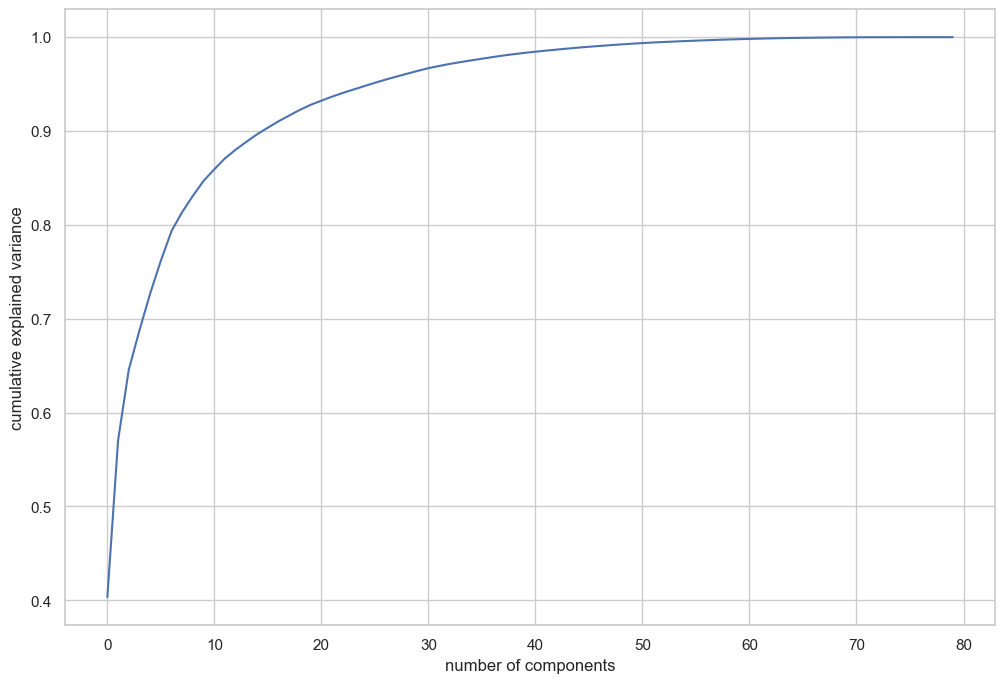

In [120]:
#lets draw screeplot in between cumulative variance and number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

**Observation:**

Plot shows that 35 components are enough to explain close to 95% variance

In [121]:
#lets perform incremental PCA for efficiency 
from sklearn.decomposition import IncrementalPCA
pca_again = IncrementalPCA(n_components=35)

In [122]:
#fit
X_train_pca = pca_again.fit_transform(X_train_smo)
X_train_pca.shape

(38430, 35)

In [123]:
#lets create correlation matrix for the principal components
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.023180842422994133 , min corr:  -0.0182037212235705


In [124]:
#correlations are close to 0

In [125]:
#Applying selected components to the test data - 35 components
X_test_pca = pca_again.transform(X_test)
X_test_pca.shape

(8986, 35)

**Modeling : Logistic Regression**

In [126]:
#import library and fit train model on train data
#class_weight="balanced":it basically means replicating the smaller class until you have as many samples as in the larger one, 
#but in an implicit way.Though we have already used smote but here we can use this too.
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
learner_pca2 = LogisticRegression(class_weight='balanced')
learner_pca2.fit(X_train_pca,y_train_smo)

LogisticRegression(class_weight='balanced')

In [127]:
#Predict on training set
dtrain_predictions = learner_pca2.predict(X_train_pca)
dtrain_predprob = learner_pca2.predict_proba(X_train_pca)[:,1]

In [128]:
#lets print some scores
print ("Accuracy :",metrics.roc_auc_score(y_train_smo, dtrain_predictions))
print ("Recall/Sensitivity :",metrics.recall_score(y_train_smo, dtrain_predictions))
print ("AUC Score (Train):",metrics.roc_auc_score(y_train_smo, dtrain_predprob))

Accuracy : 0.839032006245121
Recall/Sensitivity : 0.8620869112672391
AUC Score (Train): 0.9112544011303945


In [129]:
#lets predict on test dataset.
#print all scores
pred_probs_test = learner_pca2.predict(X_test_pca)
confusion = metrics.confusion_matrix(y_test, pred_probs_test)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Roc_auc_score :",(metrics.roc_auc_score(y_test, pred_probs_test)))
print('precision score:',(metrics.precision_score(y_test, pred_probs_test)))
print('Sensitivity/Recall :',(TP / float(TP+FN)))
print('Specificity:',(TN / float(TN+FP)))
print('False Positive Rate:',(FP/ float(TN+FP)))
print('Positive predictive value:',(TP / float(TP+FP)))
print('Negative Predictive value:',(TN / float(TN+ FN)))
print("Accuracy :",(metrics.accuracy_score(y_test,pred_probs_test)))

Roc_auc_score : 0.8143024609664047
precision score: 0.25710357470210815
Sensitivity/Recall : 0.8237885462555066
Specificity: 0.8048163756773028
False Positive Rate: 0.19518362432269717
Positive predictive value: 0.25710357470210815
Negative Predictive value: 0.982363315696649
Accuracy : 0.8062541731582462


In [130]:
#lets check with probability cutoff 0.5
y_train_pred = learner_pca2.predict_proba(X_train_pca)[:,1]
y_train_pred_final = pd.DataFrame({'Churn':y_train_smo, 'Churn_Prob':y_train_pred})
y_train_pred_final['Churn_Prob'] = y_train_pred
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0,0.16,0
1,0,0.84,1
2,0,0.18,0
3,0,0.22,0
4,0,0.04,0


In [131]:
#lets define function for ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [132]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

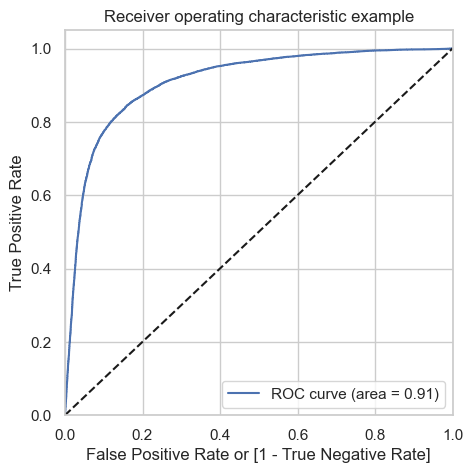

In [133]:
#lets draw roc curve
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [134]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.16,0,1,1,0,0,0,0,0,0,0,0
1,0,0.84,1,1,1,1,1,1,1,1,1,1,0
2,0,0.18,0,1,1,0,0,0,0,0,0,0,0
3,0,0.22,0,1,1,1,0,0,0,0,0,0,0
4,0,0.04,0,1,0,0,0,0,0,0,0,0,0


In [135]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

                     prob             accuracy                sensi  \
0.00                 0.00                 0.50                 1.00   
0.10                 0.10                 0.68                 0.98   
0.20                 0.20                 0.75                 0.96   
0.30                 0.30                 0.80                 0.94   
0.40                 0.40                 0.83                 0.91   
0.50                 0.50                 0.84                 0.86   
0.60                 0.60                 0.84                 0.81   
0.70                 0.70                 0.83                 0.74   
0.80                 0.80                 0.77                 0.59   
0.90                 0.90                 0.58                 0.18   

                    speci  
0.00                 0.00  
0.10                 0.39  
0.20                 0.55  
0.30                 0.66  
0.40                 0.75  
0.50                 0.82  
0.60                 0

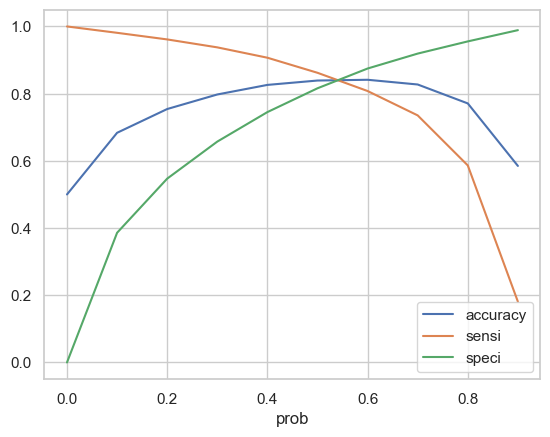

In [136]:
#lets plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

From the curve above, 0.55 is the optimum point to take it as a cutoff probability.

In [137]:
#apply cutoff probability
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.55 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.16,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.84,1,1,1,1,1,1,1,1,1,1,0,1
2,0,0.18,0,1,1,0,0,0,0,0,0,0,0,0
3,0,0.22,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.04,0,1,0,0,0,0,0,0,0,0,0,0


In [138]:
#lets predict on train dataset with optimal cutoff probability
y_train_pred = learner_pca2.predict_proba(X_train_pca)[:,1]
y_train_pred_final = pd.DataFrame({'Churn':y_train_smo, 'Churn_Prob':y_train_pred})
y_train_pred_final['Churn_Prob'] = y_train_pred
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.55 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0,0.16,0
1,0,0.84,1
2,0,0.18,0
3,0,0.22,0
4,0,0.04,0


In [139]:
#lets find out all scores of train dataset
#print all scores
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Roc_auc_score :",(metrics.roc_auc_score(y_train_pred_final.Churn, y_train_pred_final.predicted)))
print('precision score:',(metrics.precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)))
print('Sensitivity/Recall :',(TP / float(TP+FN)))
print('Specificity:',(TN / float(TN+FP)))
print('False Positive Rate:',(FP/ float(TN+FP)))
print('Positive predictive value:',(TP / float(TP+FP)))
print('Negative Predictive value:',(TN / float(TN+ FN)))

Roc_auc_score : 0.8411137132448608
precision score: 0.8453553928025712
Sensitivity/Recall : 0.8349726775956284
Specificity: 0.8472547488940931
False Positive Rate: 0.15274525110590684
Positive predictive value: 0.8453553928025712
Negative Predictive value: 0.8369749627268521


In [140]:
#lets predict on test datset with optimal cutoff obtained earlier
y_test_pred = learner_pca2.predict_proba(X_test_pca)[:,1]
y_test_pred_final = pd.DataFrame({'Churn':y_test, 'Churn_Prob':y_test_pred})
y_test_pred_final['Churn_Prob'] = y_test_pred
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.45 else 0)
y_test_pred_final.head()

,Churn,Churn_Prob,predicted
48388,0,0.24,0
29754,0,0.02,0
50131,0,0.06,0
66630,0,0.24,0
91920,0,0.18,0


In [141]:
#lets find out all scores of test dataset
#print all scores
confusion = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.predicted)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Roc_auc_score :",metrics.roc_auc_score(y_test_pred_final.Churn, y_test_pred_final.predicted))
print('precision score :',(metrics.precision_score(y_test_pred_final.Churn, y_test_pred_final.predicted)))
print('Sensitivity/Recall :',(TP / float(TP+FN)))
print('Specificity:',(TN / float(TN+FP)))
print('False Positive Rate:',(FP/ float(TN+FP)))
print('Positive predictive value:',(TP / float(TP+FP)))
print('Negative Predictive value:',(TN / float(TN+ FN)))

Roc_auc_score : 0.8101309209019918
precision score : 0.23181454836131096
Sensitivity/Recall : 0.8516886930983847
Specificity: 0.768573148705599
False Positive Rate: 0.23142685129440096
Positive predictive value: 0.23181454836131096
Negative Predictive value: 0.9844231955582974


**Observation:**
As we can see above 

stats with logistics regression on Test Dataset is:

Sensitivity/Recall :0.8516886930983847
Specificity: 0.768573148705599

Stats On Train dataset was:

Sensitivity/Recall : 0.8349726775956284
Specificity: 0.8472027062190997

**Lets apply Random forest Modeling**

Tuning max_depth

Let's try to find the optimum values for max_depth and understand how the value of max_depth impacts the overall accuracy of the ensemble.

In [142]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(10, 30, 5)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                 return_train_score=True)
rf.fit(X_train_pca, y_train_smo)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(10, 30, 5)},
             return_train_score=True, scoring='accuracy')

In [143]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,15.21,1.43,0.09,0.02,10,{'max_depth': 10},0.89,0.90,0.91,0.89,0.89,0.90,0.01,4,0.92,0.92,0.93,0.93,0.92,0.92,0.00
1,18.19,0.07,0.10,0.00,15,{'max_depth': 15},0.94,0.94,0.94,0.93,0.93,0.94,0.00,3,0.98,0.98,0.98,0.98,0.98,0.98,0.00
2,20.54,0.18,0.11,0.01,20,{'max_depth': 20},0.94,0.95,0.95,0.94,0.94,0.94,0.00,2,0.99,0.99,0.99,0.99,0.99,0.99,0.00
3,21.45,0.11,0.11,0.00,25,{'max_depth': 25},0.95,0.95,0.95,0.95,0.94,0.95,0.00,1,0.99,0.99,0.99,1.00,1.00,1.00,0.00


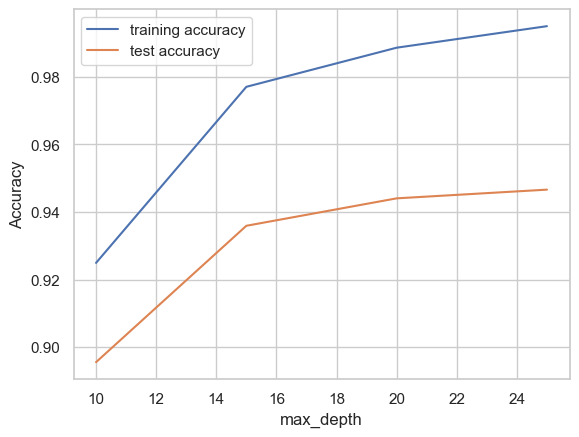

In [144]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Observation:**

max_depth 20 looks good.

We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomes constant. The ensemble tries to overfit as we increase the max_depth. Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest.

**Tuning n_estimators**

Let's try to find the optimum values for n_estimators and understand how the value of n_estimators impacts the overall accuracy. Notice that we'll specify an appropriately low value of max_depth, so that the trees do not overfit.

In [145]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(50, 150, 25)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=20)

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train_pca, y_train_smo)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=20),
             param_grid={'n_estimators': range(50, 150, 25)},
             return_train_score=True, scoring='accuracy')

In [146]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.16,0.22,0.06,0.00,50,{'n_estimators': 50},0.94,0.94,0.95,0.94,0.94,0.94,0.00,4,0.99,0.99,0.99,0.99,0.99,0.99,0.00
1,15.38,0.35,0.09,0.01,75,{'n_estimators': 75},0.95,0.95,0.95,0.94,0.94,0.94,0.00,2,0.99,0.99,0.99,0.99,0.99,0.99,0.00
2,20.29,0.31,0.11,0.00,100,{'n_estimators': 100},0.95,0.94,0.95,0.94,0.94,0.94,0.00,3,0.99,0.99,0.99,0.99,0.99,0.99,0.00
3,25.76,0.79,0.14,0.01,125,{'n_estimators': 125},0.94,0.95,0.95,0.94,0.94,0.94,0.00,1,0.99,0.99,0.99,0.99,0.99,0.99,0.00


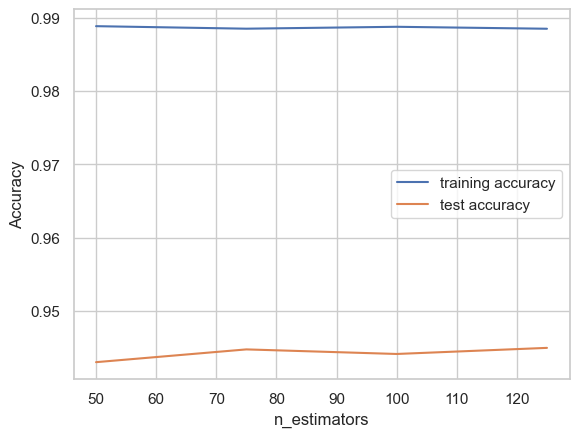

In [147]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Observation**

n_estimators 80 looks good.


**Tuning max_features**

Let's see how the model performance varies with max_features, which is the maximum numbre of features considered for splitting at a node.

In [148]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=20,n_estimators=80)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train_pca, y_train_smo)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=20, n_estimators=80),
             param_grid={'max_features': [4, 8, 14, 20, 24]},
             return_train_score=True, scoring='accuracy')

In [149]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.29,0.49,0.09,0.01,4,{'max_features': 4},0.94,0.94,0.95,0.94,0.94,0.94,0.00,1,0.99,0.99,0.99,0.99,0.99,0.99,0.00
1,25.24,0.11,0.09,0.00,8,{'max_features': 8},0.94,0.94,0.95,0.94,0.94,0.94,0.00,2,0.99,0.99,0.99,0.99,0.99,0.99,0.00
2,44.39,0.88,0.09,0.01,14,{'max_features': 14},0.94,0.94,0.95,0.94,0.94,0.94,0.00,3,0.99,0.99,0.99,0.99,0.99,0.99,0.00
3,64.86,2.17,0.11,0.05,20,{'max_features': 20},0.94,0.94,0.95,0.94,0.94,0.94,0.00,4,0.99,0.99,0.99,0.99,0.99,0.99,0.00
4,76.74,1.91,0.08,0.00,24,{'max_features': 24},0.94,0.94,0.95,0.94,0.94,0.94,0.00,5,0.99,0.99,0.99,0.99,0.99,0.99,0.00


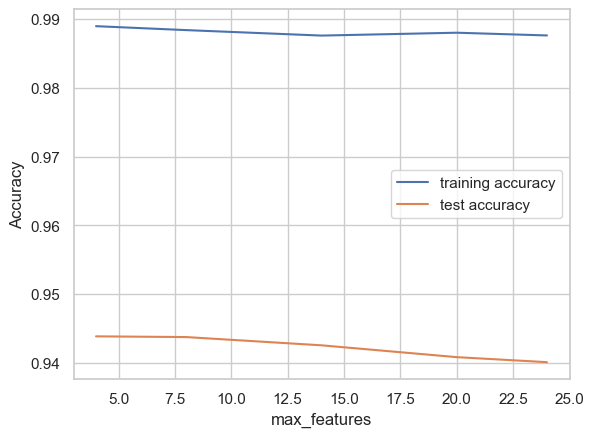

In [150]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting max_features = 5

**Tuning min_samples_leaf**

The hyperparameter min_samples_leaf is the minimum number of samples required to be at a leaf node:

If int, then consider min_samples_leaf as the minimum number.

If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

In [151]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(max_depth=20,n_estimators=80,max_features=5)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train_pca, y_train_smo)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=20, max_features=5,
                                              n_estimators=80),
             param_grid={'min_samples_leaf': range(100, 400, 50)},
             return_train_score=True, scoring='accuracy')

In [152]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.21,0.46,0.06,0.00,100,{'min_samples_leaf': 100},0.85,0.86,0.87,0.85,0.86,0.86,0.01,1,0.87,0.87,0.87,0.87,0.87,0.87,0.00
1,8.87,0.12,0.05,0.00,150,{'min_samples_leaf': 150},0.84,0.85,0.86,0.85,0.85,0.85,0.01,2,0.86,0.86,0.86,0.86,0.86,0.86,0.00
2,8.22,0.15,0.05,0.00,200,{'min_samples_leaf': 200},0.84,0.85,0.86,0.84,0.85,0.85,0.01,3,0.85,0.85,0.85,0.85,0.85,0.85,0.00
3,7.80,0.13,0.05,0.00,250,{'min_samples_leaf': 250},0.83,0.85,0.85,0.84,0.85,0.84,0.01,4,0.85,0.85,0.85,0.85,0.85,0.85,0.00
4,7.41,0.09,0.05,0.00,300,{'min_samples_leaf': 300},0.83,0.84,0.85,0.84,0.85,0.84,0.01,5,0.85,0.84,0.84,0.85,0.85,0.85,0.00


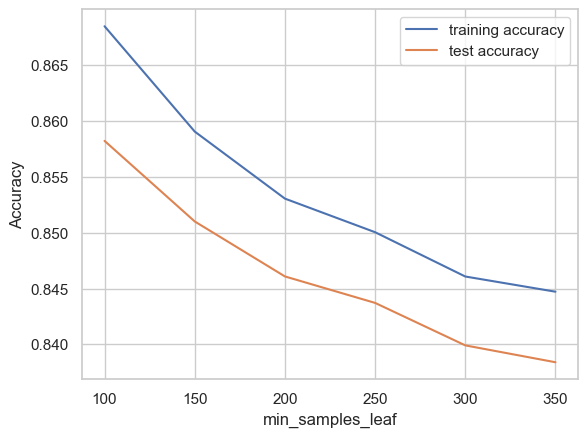

In [153]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf 100 looks good

**Tuning min_samples_split**

Let's now look at the performance of the ensemble as we vary min_samples_split.

In [154]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(50, 300, 50)}

# instantiate the model
rf = RandomForestClassifier(max_depth=20,n_estimators=80,max_features=5,min_samples_leaf=100)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_train_pca, y_train_smo)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=20, max_features=5,
                                              min_samples_leaf=100,
                                              n_estimators=80),
             param_grid={'min_samples_split': range(50, 300, 50)},
             return_train_score=True, scoring='accuracy')

In [155]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.44,0.19,0.06,0.01,50,{'min_samples_split': 50},0.85,0.86,0.87,0.85,0.86,0.86,0.01,4,0.87,0.87,0.87,0.87,0.87,0.87,0.00
1,10.02,0.16,0.06,0.00,100,{'min_samples_split': 100},0.85,0.86,0.87,0.85,0.86,0.86,0.01,2,0.87,0.87,0.87,0.87,0.87,0.87,0.00
2,9.97,0.19,0.06,0.00,150,{'min_samples_split': 150},0.85,0.86,0.87,0.85,0.86,0.86,0.01,3,0.87,0.87,0.87,0.87,0.87,0.87,0.00
3,10.23,0.48,0.06,0.00,200,{'min_samples_split': 200},0.85,0.86,0.86,0.85,0.86,0.86,0.01,1,0.87,0.87,0.87,0.87,0.87,0.87,0.00
4,9.83,0.11,0.06,0.00,250,{'min_samples_split': 250},0.85,0.86,0.86,0.85,0.86,0.86,0.00,5,0.87,0.86,0.87,0.87,0.87,0.87,0.00


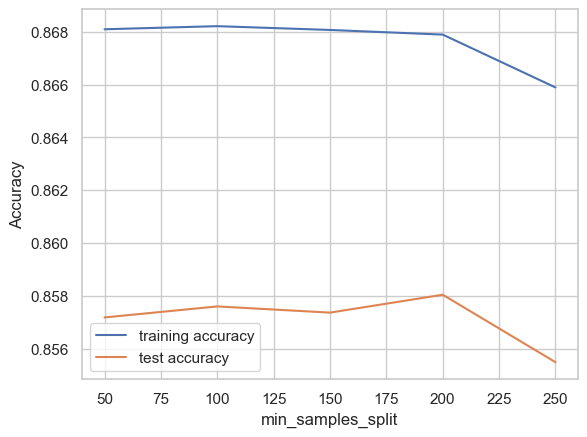

In [156]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_split looks good for 100.

**Fitting the final model with the best parameters obtained.**

In [157]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=20,
                             min_samples_leaf=100, 
                             min_samples_split=100,
                             max_features=5,
                             n_estimators=80,
                             random_state=10)

In [158]:
# fit
rf_pca=rfc.fit(X_train_pca,y_train_smo)
#Predict on training set
rtrain_predictions = rf_pca.predict(X_train_pca)
rtrain_predprob = rf_pca.predict_proba(X_train_pca)[:,1]

In [159]:
#lets print some scores
print ("Accuracy :",metrics.roc_auc_score(y_train_smo, rtrain_predictions))
print ("Recall/Sensitivity :",metrics.recall_score(y_train_smo, rtrain_predictions))
print ("AUC Score (Train):",metrics.roc_auc_score(y_train_smo, rtrain_predprob))

Accuracy : 0.8727296383034088
Recall/Sensitivity : 0.8567785584179026
AUC Score (Train): 0.9451222518728692


In [160]:
#lets predict on test dataset
pred_probs_test = rf_pca.predict(X_test_pca)
confusion = metrics.confusion_matrix(y_test, pred_probs_test)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Roc_auc_score :",(metrics.roc_auc_score(y_test, pred_probs_test)))
print('precision score:',(metrics.precision_score(y_test, pred_probs_test)))
print('Sensitivity/Recall :',(TP / float(TP+FN)))
print('Specificity:',(TN / float(TN+FP)))
print('False Positive Rate:',(FP/ float(TN+FP)))
print('Positive predictive value:',(TP / float(TP+FP)))
print('Negative Predictive value:',(TN / float(TN+ FN)))
print("Accuracy :",(metrics.accuracy_score(y_test,pred_probs_test)))

Roc_auc_score : 0.807238796931594
precision score: 0.32790091264667537
Sensitivity/Recall : 0.7386196769456681
Specificity: 0.8758579169175196
False Positive Rate: 0.12414208308248044
Positive predictive value: 0.32790091264667537
Negative Predictive value: 0.9761137949543747
Accuracy : 0.8654573781437792


In [161]:
#lets check with probability cutoff 0.5
y_train_predrf = rf_pca.predict_proba(X_train_pca)[:,1]
y_train_predrf_final = pd.DataFrame({'Churn':y_train_smo, 'Churn_Prob':y_train_predrf})
y_train_predrf_final['Churn_Prob'] = y_train_predrf
y_train_predrf_final['predicted'] = y_train_predrf_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_predrf_final.head()

,Churn,Churn_Prob,predicted
0,0,0.25,0
1,0,0.84,1
2,0,0.31,0
3,0,0.25,0
4,0,0.24,0


In [162]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_predrf_final[i]= y_train_predrf_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_predrf_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.25,0,1,1,1,0,0,0,0,0,0,0
1,0,0.84,1,1,1,1,1,1,1,1,1,1,0
2,0,0.31,0,1,1,1,1,0,0,0,0,0,0
3,0,0.25,0,1,1,1,0,0,0,0,0,0,0
4,0,0.24,0,1,1,1,0,0,0,0,0,0,0


In [163]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_predrf_final.Churn, y_train_predrf_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

                     prob             accuracy                sensi  \
0.00                 0.00                 0.50                 1.00   
0.10                 0.10                 0.55                 1.00   
0.20                 0.20                 0.72                 0.99   
0.30                 0.30                 0.83                 0.97   
0.40                 0.40                 0.87                 0.92   
0.50                 0.50                 0.87                 0.86   
0.60                 0.60                 0.85                 0.77   
0.70                 0.70                 0.81                 0.65   
0.80                 0.80                 0.73                 0.47   
0.90                 0.90                 0.60                 0.20   

                    speci  
0.00                 0.00  
0.10                 0.10  
0.20                 0.44  
0.30                 0.69  
0.40                 0.82  
0.50                 0.89  
0.60                 0

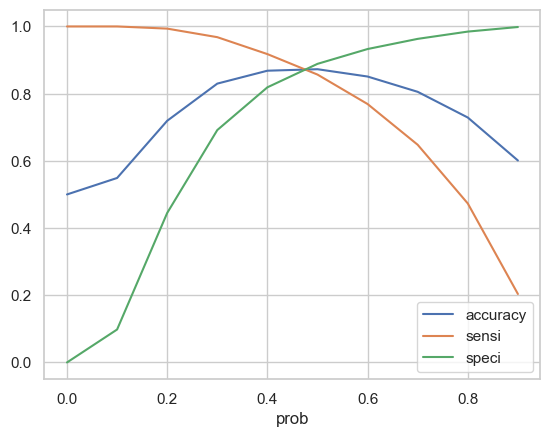

In [164]:
#lets plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

From the curve above, 0.45 is the optimum point to take it as a cutoff probability.

In [165]:
#apply cutoff probability
y_train_predrf_final['final_predicted'] = y_train_predrf_final.Churn_Prob.map( lambda x: 1 if x > 0.45 else 0)
#lets predict on train dataset with optimal cutoff probability
y_train_predrf = rf_pca.predict_proba(X_train_pca)[:,1]
y_train_predrf_final = pd.DataFrame({'Churn':y_train_smo, 'Churn_Prob':y_train_predrf})
y_train_predrf_final['Churn_Prob'] = y_train_predrf
y_train_predrf_final['predicted'] = y_train_predrf_final.Churn_Prob.map(lambda x: 1 if x > 0.45 else 0)
y_train_predrf_final.head()

,Churn,Churn_Prob,predicted
0,0,0.25,0
1,0,0.84,1
2,0,0.31,0
3,0,0.25,0
4,0,0.24,0


In [166]:
#lets find out all scores of train dataset
confusion = metrics.confusion_matrix(y_train_predrf_final.Churn, y_train_predrf_final.predicted)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Roc_auc_score :",(metrics.roc_auc_score(y_train_predrf_final.Churn, y_train_predrf_final.predicted)))
print('precision score:',(metrics.precision_score(y_train_predrf_final.Churn, y_train_predrf_final.predicted)))
print('Sensitivity/Recall :',(TP / float(TP+FN)))
print('Specificity:',(TN / float(TN+FP)))
print('False Positive Rate:',(FP/ float(TN+FP)))
print('Positive predictive value:',(TP / float(TP+FP)))
print('Negative Predictive value:',(TN / float(TN+ FN)))

Roc_auc_score : 0.8739786625032526
precision score: 0.8611055276381909
Sensitivity/Recall : 0.8918032786885246
Specificity: 0.8561540463179808
False Positive Rate: 0.14384595368201925
Positive predictive value: 0.8611055276381909
Negative Predictive value: 0.8878035617916892


In [167]:
#lets predict on test datset with optimal cutoff obtained earlier
y_test_predrf = rf_pca.predict_proba(X_test_pca)[:,1]
y_test_predrf_final = pd.DataFrame({'Churn':y_test, 'Churn_Prob':y_test_predrf})
y_test_predrf_final['Churn_Prob'] = y_test_predrf
y_test_predrf_final['predicted'] = y_test_predrf_final.Churn_Prob.map(lambda x: 1 if x > 0.45 else 0)
y_test_predrf_final.head()

,Churn,Churn_Prob,predicted
48388,0,0.34,0
29754,0,0.15,0
50131,0,0.27,0
66630,0,0.39,0
91920,0,0.26,0


In [168]:
#lets find out all scores of test dataset
confusion = metrics.confusion_matrix(y_test_predrf_final.Churn, y_test_predrf_final.predicted)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Roc_auc_score :",metrics.roc_auc_score(y_test_predrf_final.Churn, y_test_predrf_final.predicted))
print('precision score :',(metrics.precision_score(y_test_predrf_final.Churn, y_test_predrf_final.predicted)))
print('Sensitivity/Recall :',(TP / float(TP+FN)))
print('Specificity:',(TN / float(TN+FP)))
print('False Positive Rate:',(FP/ float(TN+FP)))
print('Positive predictive value:',(TP / float(TP+FP)))
print('Negative Predictive value:',(TN / float(TN+ FN)))

Roc_auc_score : 0.8155738320863624
precision score : 0.2927362097214637
Sensitivity/Recall : 0.7870778267254038
Specificity: 0.8440698374473209
False Positive Rate: 0.1559301625526791
Positive predictive value: 0.2927362097214637
Negative Predictive value: 0.9797344514325647


Train and test Recall score of Random forest:

Train Sensitivity/Recall: 0.8918032786885246

Test Sensitivity/Recall: 0.7870778267254038

Train and test Recall score with logistics regression :

Train Sensitivity/Recall: 0.8349726775956284

Test Sensitivity/Recall : 0.8516886930983847

**Observations :-**

Recall/Sensitivity score need to be considered in this case study as Telecom company will not like any high value customer to churn so will try to find out all high value customers who may leave in future. Company may willing to even bear burden of few customers who may not churn but will be classified as churn.so overall recall score will be considered for good model. Logistics Regression will be chosen in this case.

As we can see that Train Recall score of Random forest is better than Logistics Regression but Test Recall score of Logistics Regression is better as compared to Random forest. Difference in between Train and test score is less for Logistics Regression which seems model is stable.

Build another model with the main objective of identifying important predictor attributes which help the business understand indicators of churn.

A good choice to identify important variables is a logistic regression model or a model from the tree family.

In case of logistic regression, make sure to handle multi-collinearity.

**Recommend strategies to manage customer churn - Random Forest**

Fitting the final model with the best parameters obtained

In [169]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=100,
                             max_features=5,
                             n_estimators=80)

In [170]:
# fit
rfc.fit(X_train_smo,y_train_smo)

RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=100,
                       min_samples_split=100, n_estimators=80)

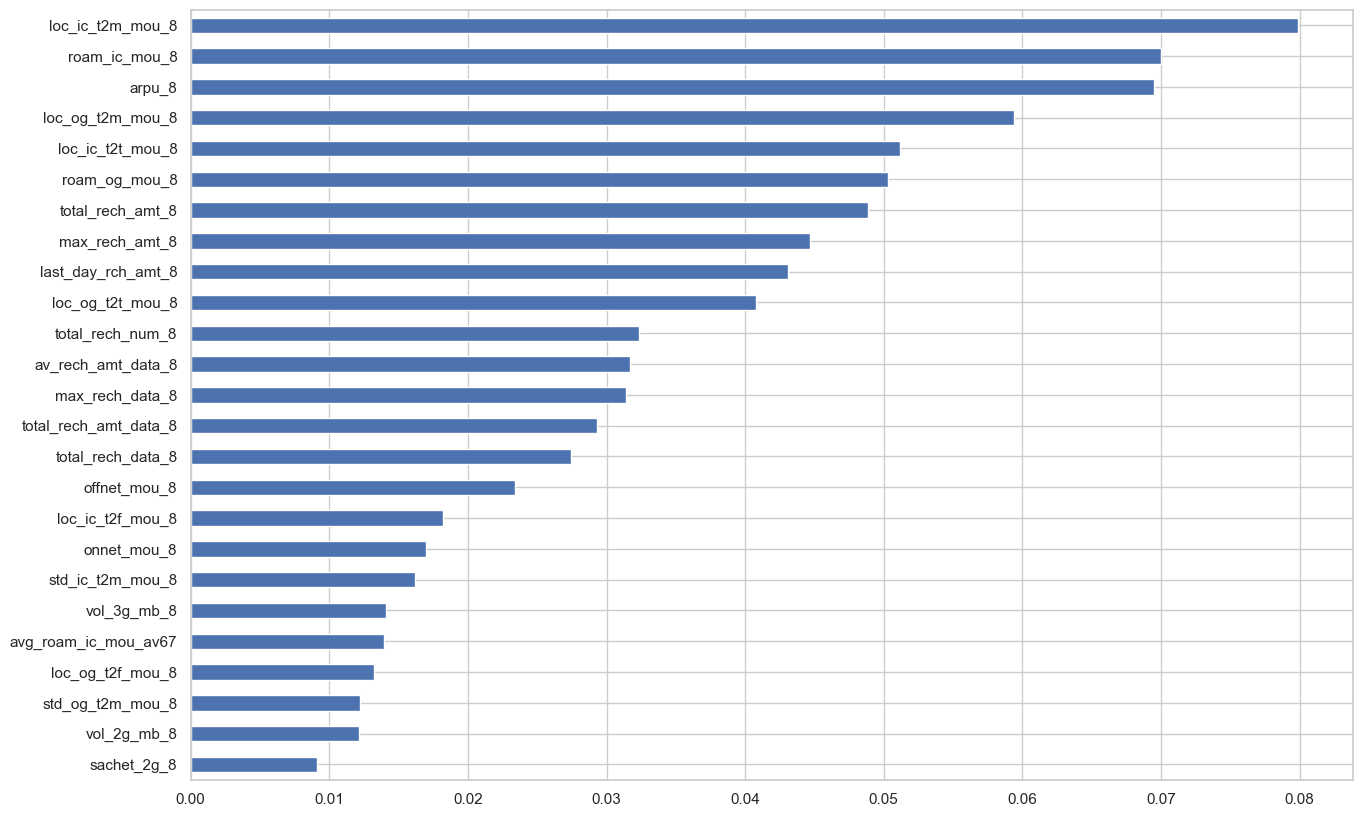

In [171]:
# Plot for important features
plt.figure(figsize=(15,10))
impo_features = pd.Series(rfc.feature_importances_, index=X.columns)
impo_features.nlargest((25)).sort_values().plot(kind='barh', align='center')
plt.show()

We could see from above plot that almost all the features of top 25 most important features are from action phase that is August month. Hence we need to focus on these features to identify high value customers who may churn in future.

Top 10 most important features are as follows:

1.loc_ic_t2m_mou_8: Local incoming call operator T to other operator mobile minutes of usage - voice calls in 8th month.

2.total_rech_amt_8: Total recharge amount in 8th month.

3.max_rech_amt_8: Max recharge amount in 8th monnth.

4.roam_ic_mou_8: Roaming incoming calls minutes of usage - voice calls in 8th month.

5.loc_ic_t2t_mou_8: Local incoming calls within same operator mobile minutes of usage - voice calls in 8th month.

6.arpu_8: Average revenue per usage in month 8.

7.total_rech_data_8: Total data recharge in month 8.

8.roam_og_mou_8: Roaming outgoing calls minutes of usage - voice calls in 8th month.

9.loc_og_t2t_mou_8: Local outgoing calls within same operator mobile minutes of usage - voice calls in 8th month.

10.total_rech_num_8: Total number of recharges done in the month 8.

**Recommended Strategies and Suggestions:**

Important factors that Telecom compnay should monitor is already mentioned above.

Number of Incoming and outgoing calls from a mobile number in particular month by customer. If number of calls starts reducing then it may be sign of customer trying to switch from one netwrok to another network or he is has already switched and using current netwrok for few days.

Recharge amount is very important factor to notice if it starts reducing month by month then it need to be looked as cutomer may not be happy with the services he is getting that is why he started recharging with less amount.

If data usage starts decreasing and in august month it is minimal then it shows customer is not getting good spped of internet.

If internet speed that customer is getting is good, customer will finsh data soon and recharge it again but if network is poor and speed is not good then customer will not be able to finish it and will not recharge it multiple times. so need to look into areas where mnetwork is poor and customer care is receiving complaints multiple times.

If all kinds of call and data usage reduces then it is serious concern as customer may be planning to churn and just timepassing for few more days. so company need to look into these ares.

If customer is using the services for incoming calls only and has stopped using outgoing calls then he is finding the services very costly and may switch to network where incoming and outgoing services are in reasonable rate.